## Self Attention in Transformers

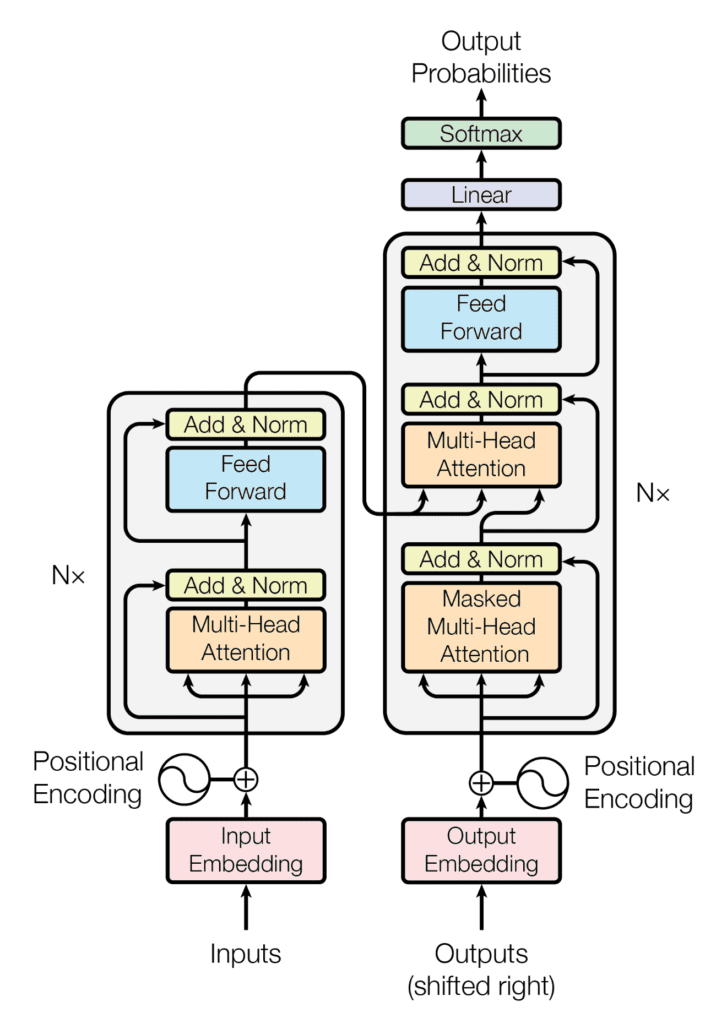

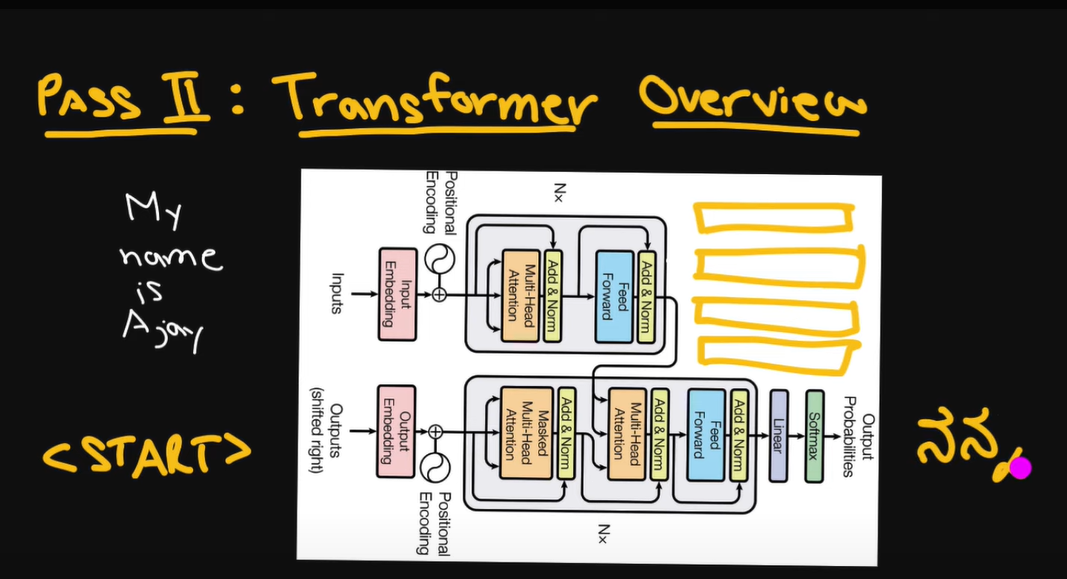

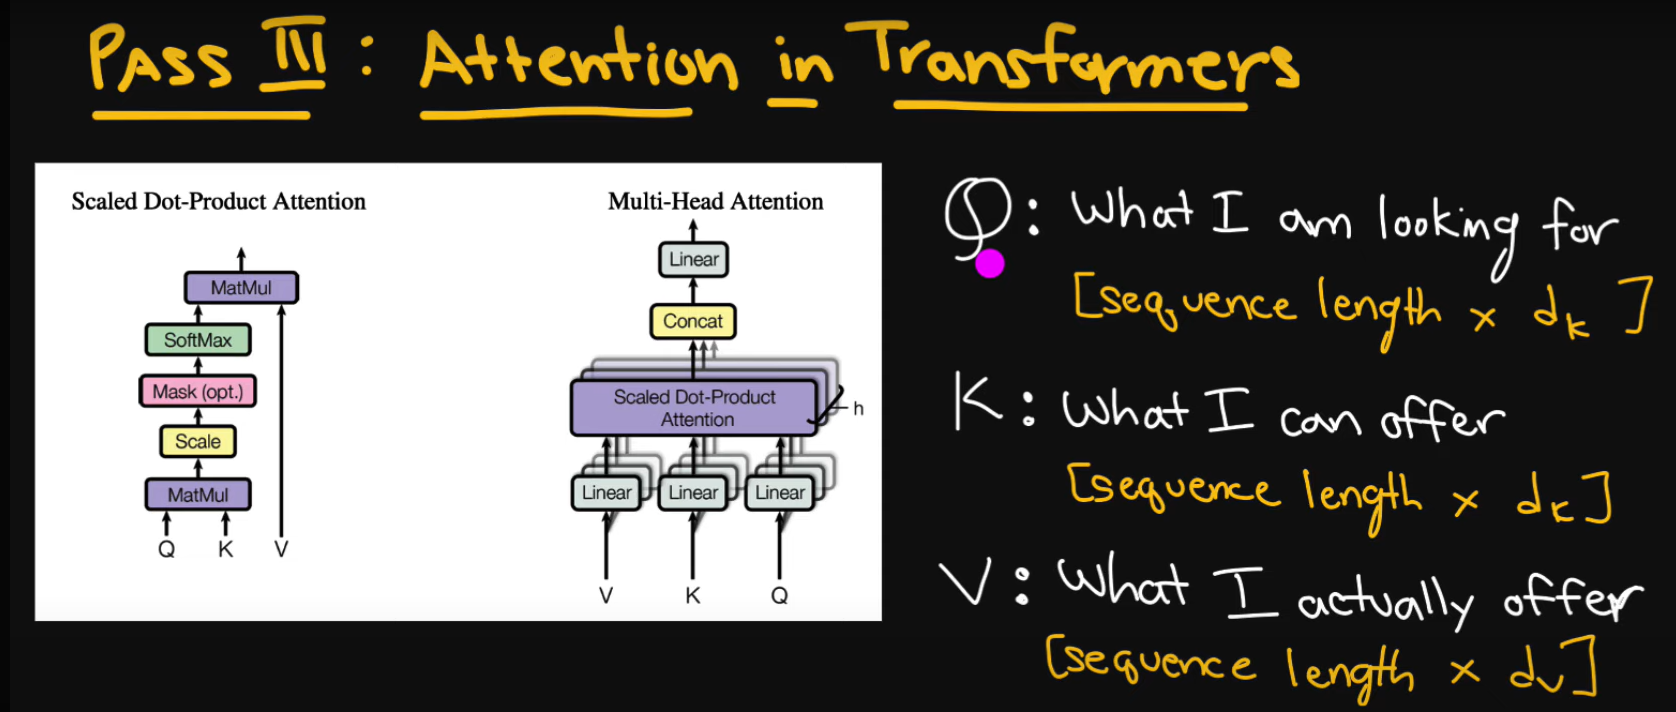

Analogy for Q, K and V can go something like this:

**Analogy**: The Library of Wisdom

- Query Librarian: The librarian who seeks information based on specific questions (queries).
- Key Librarian: Another librarian who holds the index of the entire library's content.
- Bookkeeper: A wise bookkeeper who stores comprehensive information in books.


**Self-Attention:**
The Query Librarian can look at the index (Key Librarian) and decide which books (Values) are most relevant for a given query. This is akin to self-attention, where each word in a sentence can attend to other words within the same sentence.


**Multi-Head Attention:**
Imagine having multiple Query Librarians, each with a different expertise or perspective. They collaborate to gather information from the Key Librarian and relevant books. This collaboration represents multi-head attention, where multiple attention mechanisms work in parallel to capture different aspects of the input.




# Self Attention
To create an initial attention matrix we need every word to look at every other single word to see if it has higher affinity between words.

\begin{equation}
\text{self attention} = softmax\bigg(\frac{Q.K^T}{\sqrt{d_k}}+M\bigg)
\\
\text{new V} = \text{self attention}.V
\end{equation}


q.kT is nothing but cosine similarity

In [ ]:
import numpy as np
import math

# L->Length of input sequence -> My name is Lakshman -> length L=4
# size of each vectors set to 8 just for illustration
L, d_k, d_v = 4, 8, 8
q = np.random.randn(L, d_k)
k = np.random.randn(L, d_k)
v = np.random.randn(L, d_v)

In [ ]:
# Every word is having all these 3 q,k,v as we can see below. the first row of q,k,v is for word **my** and similarly the second row is for **name**
print("Q\n", q)
print("K\n", k)
print("V\n", v)

Q
 [[ 0.19921316  0.41662341  2.19189933  0.42031991  1.03433013 -0.00727858
  -1.71150658 -0.33395656]
 [-0.09523443 -1.79376053 -0.06552749 -0.61954235 -0.52036644  1.35671083
   1.28632601 -0.11978776]
 [ 0.24834258  1.34491758 -0.38089569  0.8193812  -0.5567864   0.67779278
  -0.31557456 -0.95467479]
 [ 0.30054604  0.63058903  0.54430749  0.68243397  3.51625543 -1.61113681
   2.32184093 -1.08195019]]
K
 [[ 0.4334182   1.04118943 -0.92063906  0.64075469  0.09719206  0.14526006
   0.07240641  1.19499412]
 [ 1.07707698 -0.45138828  0.58506899  0.89540448 -0.77036134  0.07154535
   1.24189202  0.47006257]
 [ 1.0781372   0.08979672 -0.53427613  0.43630221 -2.56113741  0.89109585
  -1.33090101 -0.90612702]
 [-0.07789322 -0.17863895  0.48374106 -0.55860976  0.42324462 -1.55641949
   0.53219633  0.08433509]]
V
 [[ 0.42802591 -1.36260651  1.91672189  1.03859383  0.97744969 -0.78491868
   1.16544222 -0.69000971]
 [ 0.2138634   1.31080848 -0.13847856 -0.8847464   0.88883695  0.80412725
   2.6

In [ ]:
np.matmul(q, k.T)

array([[ -1.65202846,  -1.39453789,  -0.81059703,   0.24565579],
       [ -2.14907534,   2.15313536,   0.43921218,  -1.01514012],
       [  1.26430058,  -0.19201539,   4.2645578 ,  -2.44061503],
       [ -0.2941029 ,   0.51941743, -12.16345517,   4.88630111]])

In [ ]:
# Why we need sqrt(d_k) in denominator
q.var(), k.var(), np.matmul(q, k.T).var()

(1.3133129966058528, 0.7433970634483709, 13.092710296226443)

In [ ]:
# as we can observe that the variance of the product is more so we have to divide it by square root of the d_k
scaled = np.matmul(q, k.T) / math.sqrt(d_k)
q.var(), k.var(), scaled.var()

(1.3133129966058528, 0.7433970634483709, 1.6365887870283053)

In [ ]:
# Comparing the above matmul operation we can observe that the values are much more normalized and in same range.
scaled

array([[-0.58408026, -0.4930436 , -0.28658933,  0.08685244],
       [-0.75981287,  0.76124831,  0.15528496, -0.35890623],
       [ 0.44699776, -0.06788769,  1.50774887, -0.86288772],
       [-0.10398108,  0.1836418 , -4.30043082,  1.72756833]])

## Masking
* This is not required in encoders but required in decoders
* This is to ensure words don't get context from words generated in future.


In [ ]:
mask = np.tril(np.ones((L,L))) # tril is a numpy function to generate upper traingular matrix
mask

array([[1., 0., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 1.]])

In [ ]:
# this means that in the first row **my** will be looking into word **my** only and in the second row **name** will look into both **my** and **name** and
# similarly in third row **is** will be looking into **my**, **name** and **is**
# This process is only required for decoder and not for the encoder

In [ ]:
mask[mask==0] = -np.infty
mask[mask==1] = 0
# why 0 because we are adding below
# why -inf because we are using softmax

In [ ]:
mask

array([[  0., -inf, -inf, -inf],
       [  0.,   0., -inf, -inf],
       [  0.,   0.,   0., -inf],
       [  0.,   0.,   0.,   0.]])

In [ ]:
scaled + mask

array([[-0.58408026,        -inf,        -inf,        -inf],
       [-0.75981287,  0.76124831,        -inf,        -inf],
       [ 0.44699776, -0.06788769,  1.50774887,        -inf],
       [-0.10398108,  0.1836418 , -4.30043082,  1.72756833]])

## Softmax
convert a vector into a probability distribution

In [ ]:
def softmax(x):
  return (np.exp(x).T / np.sum(np.exp(x), axis=-1)).T

In [ ]:
attention = softmax(scaled + mask)

In [ ]:
attention

array([[1.        , 0.        , 0.        , 0.        ],
       [0.17930531, 0.82069469, 0.        , 0.        ],
       [0.22291033, 0.13320431, 0.64388536, 0.        ],
       [0.11638928, 0.15517653, 0.00175153, 0.72668266]])

In [ ]:
new_v = np.matmul(attention, v)
new_v # this matrix should better encapsulate the context of the word

array([[ 0.42802591, -1.36260651,  1.91672189,  1.03859383,  0.97744969,
        -0.78491868,  1.16544222, -0.69000971],
       [ 0.25226387,  0.83145098,  0.23002979, -0.53988129,  0.90472568,
         0.51920288,  2.39753578, -0.08287587],
       [ 0.26834759,  0.12974278,  0.93383525,  0.3492687 , -0.29416568,
         0.07565074,  0.44038668, -0.02077451],
       [-0.57358819, -0.22718453,  1.26692064,  0.1065259 ,  0.44170572,
        -0.51979485,  1.75873849,  0.16594236]])

In [ ]:
v

array([[ 0.42802591, -1.36260651,  1.91672189,  1.03859383,  0.97744969,
        -0.78491868,  1.16544222, -0.69000971],
       [ 0.2138634 ,  1.31080848, -0.13847856, -0.8847464 ,  0.88883695,
         0.80412725,  2.66672348,  0.04977068],
       [ 0.2243391 ,  0.40205372,  0.81539994,  0.3659152 , -0.97912806,
         0.22287198, -0.27119967,  0.19631773],
       [-0.90408837, -0.37527062,  1.46404371,  0.16829309,  0.26384199,
        -0.76183291,  1.6647647 ,  0.32777031]])

#Function

In [ ]:
def softmax(x):
  return (np.exp(x).T / np.sum(np.exp(x), axis=-1)).T

def scaled_dot_product_attention(q, k, v, mask=None): # we can use this mask only in decoder by passing the mask value
  d_k = q.shape[-1]
  scaled = np.matmul(q, k.T) / math.sqrt(d_k)
  if mask is not None:
    scaled = scaled + mask
  attention = softmax(scaled)
  out = np.matmul(attention, v)
  return out, attention



In [ ]:
values, attention = scaled_dot_product_attention(q, k, v, mask=mask)
print("Q\n", q)
print("K\n", k)
print("V\n", v)
print("New V\n", values)
print("Attention\n", attention)

Q
 [[ 0.19921316  0.41662341  2.19189933  0.42031991  1.03433013 -0.00727858
  -1.71150658 -0.33395656]
 [-0.09523443 -1.79376053 -0.06552749 -0.61954235 -0.52036644  1.35671083
   1.28632601 -0.11978776]
 [ 0.24834258  1.34491758 -0.38089569  0.8193812  -0.5567864   0.67779278
  -0.31557456 -0.95467479]
 [ 0.30054604  0.63058903  0.54430749  0.68243397  3.51625543 -1.61113681
   2.32184093 -1.08195019]]
K
 [[ 0.4334182   1.04118943 -0.92063906  0.64075469  0.09719206  0.14526006
   0.07240641  1.19499412]
 [ 1.07707698 -0.45138828  0.58506899  0.89540448 -0.77036134  0.07154535
   1.24189202  0.47006257]
 [ 1.0781372   0.08979672 -0.53427613  0.43630221 -2.56113741  0.89109585
  -1.33090101 -0.90612702]
 [-0.07789322 -0.17863895  0.48374106 -0.55860976  0.42324462 -1.55641949
   0.53219633  0.08433509]]
V
 [[ 0.42802591 -1.36260651  1.91672189  1.03859383  0.97744969 -0.78491868
   1.16544222 -0.69000971]
 [ 0.2138634   1.31080848 -0.13847856 -0.8847464   0.88883695  0.80412725
   2.6

This was only result of single attention head, and when we stack the results to get the multi head attention

#Multi Head Attention in Transforners




Multi-head Attention
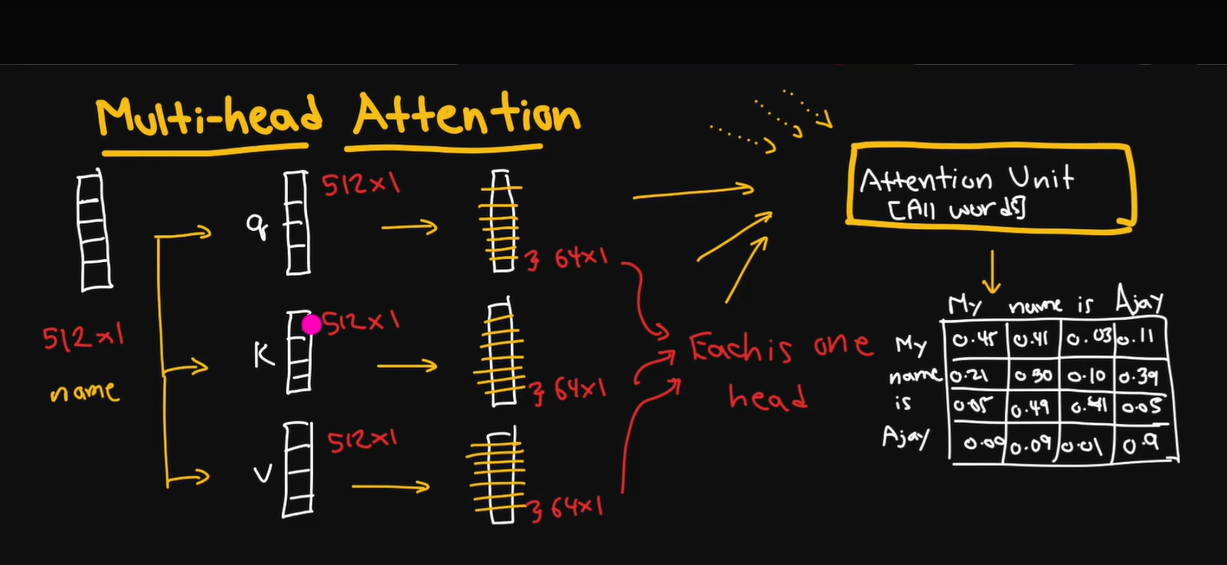

**name** word with 512 dimensional vector which is break down into 3 components
Here the components are the same query, key and value vectors which are then again divided into multiple heads
Every word will have
- query vector: what am I looking for.
- key vector: what I can offer.
- value vector: what I actually offer.

Again each of these vectors are broken into 8 heads where each head is fed into attention unit, which we will look below.

In the right side you can see the matrix
We have 8 such attention matrices as we have 8 attention heads.

**The goal of the attention**: making the input word vector more contextually aware.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
sequence_length = 4
batch_size = 1
input_dim = 512 # length of the every word - embedding length
d_model = 512 # output of the dimension unit
x = torch.randn((batch_size, sequence_length, input_dim)) # here x is after positional encoding. so generating random numbers

In [ ]:
x.size()

torch.Size([1, 4, 512])

In [ ]:
qkv_layer = nn.Linear(input_dim, 3*d_model) # to concatenate the qkv vectors into single vector.

In [ ]:
qkv_layer

Linear(in_features=512, out_features=1536, bias=True)

In [ ]:
qkv = qkv_layer(x)

In [ ]:
qkv.shape # 1 batch 4 words of each having qkv vectors combined - 1536 dimension

torch.Size([1, 4, 1536])

In [ ]:
num_heads = 8 # 8 attention heads
head_dim = d_model // num_heads # 512 / 8 -> 64
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3 * head_dim) # 3 is for qkv

In [ ]:
qkv.shape

torch.Size([1, 4, 8, 192])

In [ ]:
# to make it easier for parallel operations we do switch the sequence_length and num_heads
qkv = qkv.permute(0,2,1,3) # [batch_size, num_heads, sequence_length, 3*head_dim]
qkv.shape

torch.Size([1, 8, 4, 192])

In [ ]:
q, k, v = qkv.chunk(3, dim=-1) # breaking by last dimension so dim=-1
q.shape, k.shape, v.shape # something like 1 batch with 8 attention heads of 4 max sequence_length of 64 qkv thing that we have split

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

#Self Attention for multiple heads

For a single head:

\begin{equation}
\text{self attention} = softmax\bigg(\frac{Q.K^T}{\sqrt{d_k}}+M\bigg)
\\
\text{new V} = \text{self attention}.V
\end{equation}

In [ ]:
d_k = q.size()[-1]
print("d_k ", d_k)

# Previously we did it in numpy, now we are doing it with pytorch
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
scaled.shape # we end up with sequence length x sequence length in the last dimension

d_k  64


torch.Size([1, 8, 4, 4])

In [ ]:
k.shape

torch.Size([1, 8, 4, 64])

In [ ]:
# We have to use transpose function as it is a 4 dimension tensor. As we can see the difference between .T and .transpose
k.T.shape, k.transpose(-2, -1).shape

<ipython-input-33-706184a5a46b>:2: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  k.T.shape, k.transpose(-2, -1).shape


(torch.Size([64, 4, 8, 1]), torch.Size([1, 8, 64, 4]))

In [ ]:
mask = torch.full(scaled.size(), float('-inf')) # fill the matrix with -inf value
mask = torch.triu(mask, diagonal=1, ) # Returns the upper triangular part of a matrix
print("mask shape", mask.shape)
mask[0][1] # mask for input to a single head

mask shape torch.Size([1, 8, 4, 4])


tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [ ]:
(scaled + mask)[0][0]

tensor([[-0.4667,    -inf,    -inf,    -inf],
        [ 0.0429, -0.1581,    -inf,    -inf],
        [ 0.2515,  0.2933, -0.2817,    -inf],
        [ 0.4424, -0.3621, -0.4524,  0.1543]], grad_fn=<SelectBackward0>)

In [ ]:
scaled += mask

In [ ]:
# Apply softmax for the scaled tensor to get the attention
attention = F.softmax(scaled, dim=-1)

In [ ]:
attention.shape # as we can see we have sequence_lenght x sequence_length with 8 attention heads

torch.Size([1, 8, 4, 4])

In [ ]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5501, 0.4499, 0.0000, 0.0000],
        [0.3803, 0.3965, 0.2231, 0.0000],
        [0.3838, 0.1717, 0.1568, 0.2877]], grad_fn=<SelectBackward0>)

In [ ]:
values = torch.matmul(attention, v)
values.shape # for 1 batch for 8 heads for 4 words we have 64 dimensional vector

torch.Size([1, 8, 4, 64])

#Function

In [ ]:
import math

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [ ]:
values, attention = scaled_dot_product(q,k,v,mask=mask)

In [ ]:
attention.shape

torch.Size([1, 8, 4, 4])

In [ ]:
attention[0][0] # we have masks, because of the mask being passed in the above scaled_dot_product method

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5501, 0.4499, 0.0000, 0.0000],
        [0.3803, 0.3965, 0.2231, 0.0000],
        [0.3838, 0.1717, 0.1568, 0.2877]], grad_fn=<SelectBackward0>)

In [ ]:
values.size()

torch.Size([1, 8, 4, 64])

In [ ]:
values = values.reshape(batch_size, sequence_length, num_heads*head_dim)

In [ ]:
values.size()

torch.Size([1, 4, 512])

In [ ]:
linear_layer = nn.Linear(d_model, d_model)

In [ ]:
out = linear_layer(values)

In [ ]:
out.shape

torch.Size([1, 4, 512])

In [ ]:
out

tensor([[[ 1.1879e-01,  3.1334e-01, -3.5183e-01,  ..., -1.0076e-01,
          -4.3021e-01,  2.0027e-01],
         [-4.2495e-01,  3.4131e-02, -1.4513e-01,  ..., -8.5603e-02,
          -1.4580e-01, -1.1409e-01],
         [ 6.2099e-02, -6.1033e-01,  1.1480e-02,  ...,  1.5849e-01,
           1.3731e-04, -3.2944e-02],
         [ 5.8235e-01, -1.5369e-02,  1.9792e-01,  ...,  1.7823e-01,
           2.8041e-01,  5.3275e-01]]], grad_fn=<ViewBackward0>)

#Class

In [ ]:
import torch
import torch.nn as nn
import math
import torch.nn.functional as F

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class MultiHeadAttention(nn.Module):

    def __init__(self, input_dim, d_model, num_heads):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(input_dim , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        batch_size, sequence_length, input_dim = x.size()
        print(f"x.size(): {x.size()} - for batch_size.{batch_size} of sequence_length.{sequence_length} with input_dim.{input_dim}")
        qkv = self.qkv_layer(x)
        print(f"qkv.size(): {qkv.size()} - qkv concatenated hence the last dim has value {qkv.size()} which is 3*d_model->{3}*{d_model}")
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        print(f"qkv.size(): {qkv.size()} - and now we divide the last dim vector into {self.num_heads} heads so we have {self.num_heads} and {3}*{self.head_dim} - (d_model//num_heads) -> 3*({d_model}//{self.num_heads})")
        qkv = qkv.permute(0, 2, 1, 3)
        print(f"qkv.size(): {qkv.size()} - swap the middle 2 dimension which makes for batch_size.{batch_size} for heads.{self.num_heads} of sequence_length.{sequence_length} with input_dim.{input_dim} ")
        q, k, v = qkv.chunk(3, dim=-1)
        print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")
        values, attention = scaled_dot_product(q, k, v, mask)
        print(f"values.size(): {values.size()}, attention.size:{ attention.size()} - and finally we have attention of sequence_length.{sequence_length} x sequence_length.{sequence_length} for {self.num_heads} heads ")
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        print(f"values.size(): {values.size()} - combining the multiple heads into a single vector of {self.d_model} dimension")
        out = self.linear_layer(values)
        print(f"out.size(): {out.size()} this is the final output size which contains for every batch_size.{batch_size} of sequence_length.{sequence_length} with d_model.{self.d_model} dimensional vector ")
        return out

In [ ]:
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
x = torch.randn( (batch_size, sequence_length, input_dim) )

model = MultiheadAttention(input_dim, d_model, num_heads)
out = model.forward(x)

x.size(): torch.Size([30, 5, 1024]) - for batch_size.30 of sequence_length.5 with input_dim.1024
qkv.size(): torch.Size([30, 5, 1536]) - qkv concatenated hence the last dim has value torch.Size([30, 5, 1536]) which is 3*d_model->3*512
qkv.size(): torch.Size([30, 5, 8, 192]) - and now we divide the last dim vector into 8 heads so we have 8 and 3*64 - (d_model//num_heads) -> 3*(512//8)
qkv.size(): torch.Size([30, 8, 5, 192]) - swap the middle 2 dimension which makes for batch_size.30 for heads.8 of sequence_length.5 with input_dim.1024 
q size: torch.Size([30, 8, 5, 64]), k size: torch.Size([30, 8, 5, 64]), v size: torch.Size([30, 8, 5, 64]), 
values.size(): torch.Size([30, 8, 5, 64]), attention.size:torch.Size([30, 8, 5, 5]) - and finally we have attention of sequence_length.5 x sequence_length.5 for 8 heads 
values.size(): torch.Size([30, 5, 512]) - combining the multiple heads into a single vector of 512 dimension
out.size(): torch.Size([30, 5, 512]) this is the final output size whic

# Position encoding in Transformers

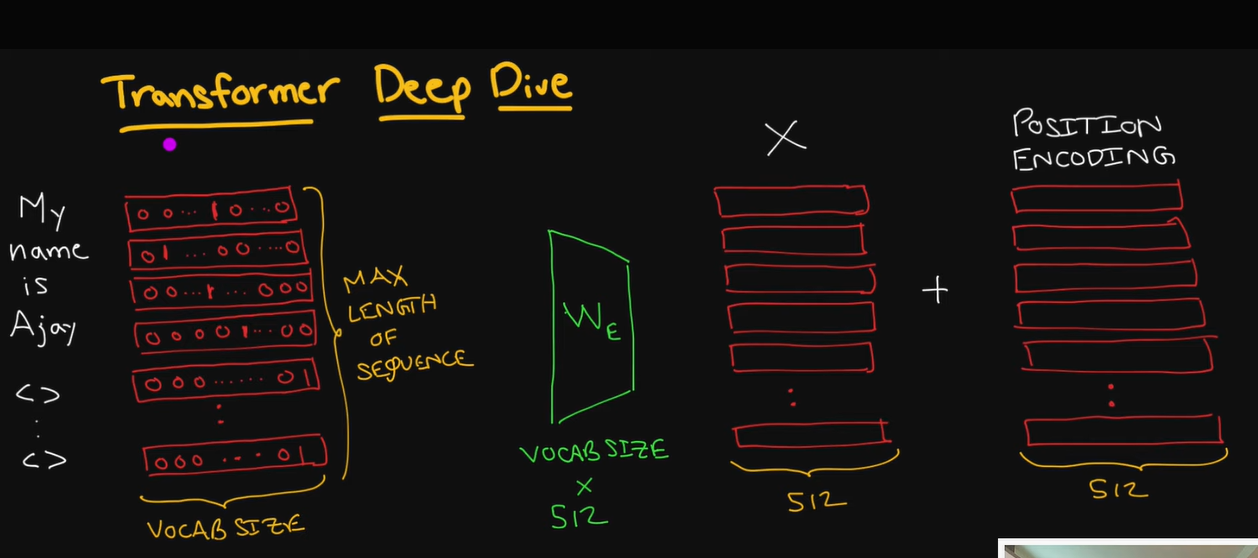

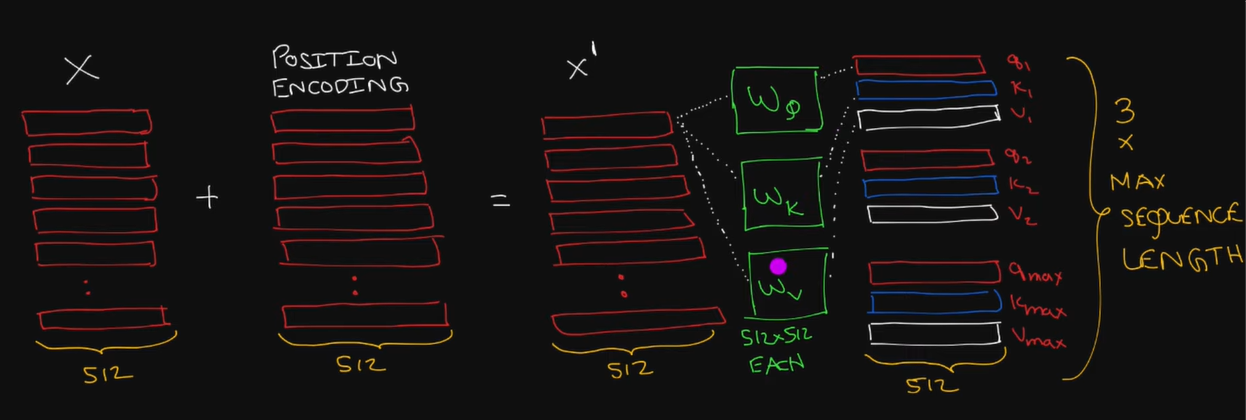

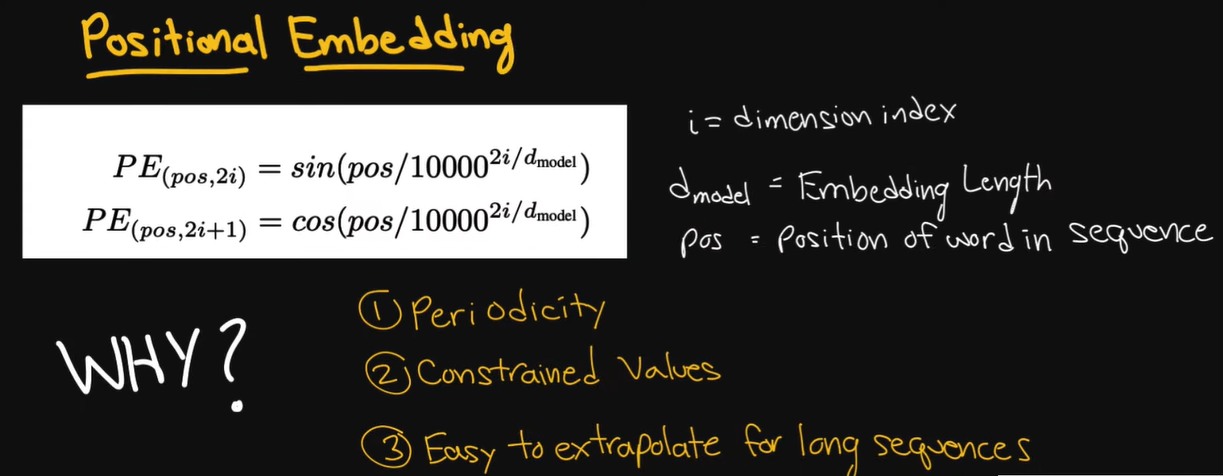

In [ ]:
import torch
import torch.nn as nn

max_sequence_length = 10
d_model = 6 # dimension of the embeddings mostly it will be 512


\begin{equation}
PE(\text{position}, 2i) = \sin\bigg( \frac{ \text{position} }{10000^\frac{2i}{d_{model}}} \bigg)
\\
PE(\text{position}, 2i+1) = \cos\bigg( \frac{ \text{position} }{10000^\frac{2i}{d_{model}}} \bigg)
\end{equation}

we can rewrite these as
\begin{equation}
PE(\text{position}, i) = \sin\bigg( \frac{ \text{position} }{10000^\frac{i}{d_{model}}} \bigg) \text{ when i is even}
\\
PE(\text{position}, i) = \cos\bigg( \frac{ \text{position} }{10000^\frac{i-1}{d_{model}}} \bigg) \text{ when i is odd}
\end{equation}



In [ ]:
even_i = torch.arange(0, d_model, 2).float()
even_i

tensor([0., 2., 4.])

In [ ]:
even_denominator = torch.pow(10000, even_i/d_model)
even_denominator

tensor([  1.0000,  21.5443, 464.1590])

In [ ]:
odd_i = torch.arange(1, d_model, 2).float()
odd_i

tensor([1., 3., 5.])

In [ ]:
odd_denominator = torch.pow(10000, (odd_i - 1)/d_model)
odd_denominator

tensor([  1.0000,  21.5443, 464.1590])

`even_denominator` and `odd_denominator` are the same! So we can just do one of these actions and call the resulting variable `denominator`

In [ ]:
denominator = even_denominator

In [ ]:
position = torch.arange(max_sequence_length, dtype=torch.float).reshape(max_sequence_length, 1)

In [ ]:
position

tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.],
        [9.]])

In [ ]:
even_PE = torch.sin(position / denominator)
odd_PE = torch.cos(position / denominator)

In [ ]:
even_PE

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.8415,  0.0464,  0.0022],
        [ 0.9093,  0.0927,  0.0043],
        [ 0.1411,  0.1388,  0.0065],
        [-0.7568,  0.1846,  0.0086],
        [-0.9589,  0.2300,  0.0108],
        [-0.2794,  0.2749,  0.0129],
        [ 0.6570,  0.3192,  0.0151],
        [ 0.9894,  0.3629,  0.0172],
        [ 0.4121,  0.4057,  0.0194]])

In [ ]:
even_PE.shape

torch.Size([10, 3])

In [ ]:
odd_PE

tensor([[ 1.0000,  1.0000,  1.0000],
        [ 0.5403,  0.9989,  1.0000],
        [-0.4161,  0.9957,  1.0000],
        [-0.9900,  0.9903,  1.0000],
        [-0.6536,  0.9828,  1.0000],
        [ 0.2837,  0.9732,  0.9999],
        [ 0.9602,  0.9615,  0.9999],
        [ 0.7539,  0.9477,  0.9999],
        [-0.1455,  0.9318,  0.9999],
        [-0.9111,  0.9140,  0.9998]])

In [ ]:
odd_PE.shape

torch.Size([10, 3])

In [ ]:
stacked = torch.stack([even_PE, odd_PE], dim=2)
stacked.shape

torch.Size([10, 3, 2])

In [ ]:
PE = torch.flatten(stacked, start_dim=1, end_dim=2)
PE.shape

torch.Size([10, 6])

In [ ]:
PE

tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0464,  0.9989,  0.0022,  1.0000],
        [ 0.9093, -0.4161,  0.0927,  0.9957,  0.0043,  1.0000],
        [ 0.1411, -0.9900,  0.1388,  0.9903,  0.0065,  1.0000],
        [-0.7568, -0.6536,  0.1846,  0.9828,  0.0086,  1.0000],
        [-0.9589,  0.2837,  0.2300,  0.9732,  0.0108,  0.9999],
        [-0.2794,  0.9602,  0.2749,  0.9615,  0.0129,  0.9999],
        [ 0.6570,  0.7539,  0.3192,  0.9477,  0.0151,  0.9999],
        [ 0.9894, -0.1455,  0.3629,  0.9318,  0.0172,  0.9999],
        [ 0.4121, -0.9111,  0.4057,  0.9140,  0.0194,  0.9998]])

# Class

In [ ]:
import torch
import torch.nn as nn

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_sequence_length):
        super().__init__()
        self.max_sequence_length = max_sequence_length
        self.d_model = d_model

    def forward(self):
        even_i = torch.arange(0, self.d_model, 2).float()
        denominator = torch.pow(10000, even_i/self.d_model)
        position = torch.arange(self.max_sequence_length).reshape(self.max_sequence_length, 1)
        even_PE = torch.sin(position / denominator)
        odd_PE = torch.cos(position / denominator)
        stacked = torch.stack([even_PE, odd_PE], dim=2)
        PE = torch.flatten(stacked, start_dim=1, end_dim=2)
        return PE

In [ ]:
pe = PositionalEncoding(d_model=6, max_sequence_length=10)
pe_output = pe.forward()
pe_output

tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0464,  0.9989,  0.0022,  1.0000],
        [ 0.9093, -0.4161,  0.0927,  0.9957,  0.0043,  1.0000],
        [ 0.1411, -0.9900,  0.1388,  0.9903,  0.0065,  1.0000],
        [-0.7568, -0.6536,  0.1846,  0.9828,  0.0086,  1.0000],
        [-0.9589,  0.2837,  0.2300,  0.9732,  0.0108,  0.9999],
        [-0.2794,  0.9602,  0.2749,  0.9615,  0.0129,  0.9999],
        [ 0.6570,  0.7539,  0.3192,  0.9477,  0.0151,  0.9999],
        [ 0.9894, -0.1455,  0.3629,  0.9318,  0.0172,  0.9999],
        [ 0.4121, -0.9111,  0.4057,  0.9140,  0.0194,  0.9998]])

In [ ]:
pe_output.shape

torch.Size([10, 6])

# Layer Normalization in Transformer

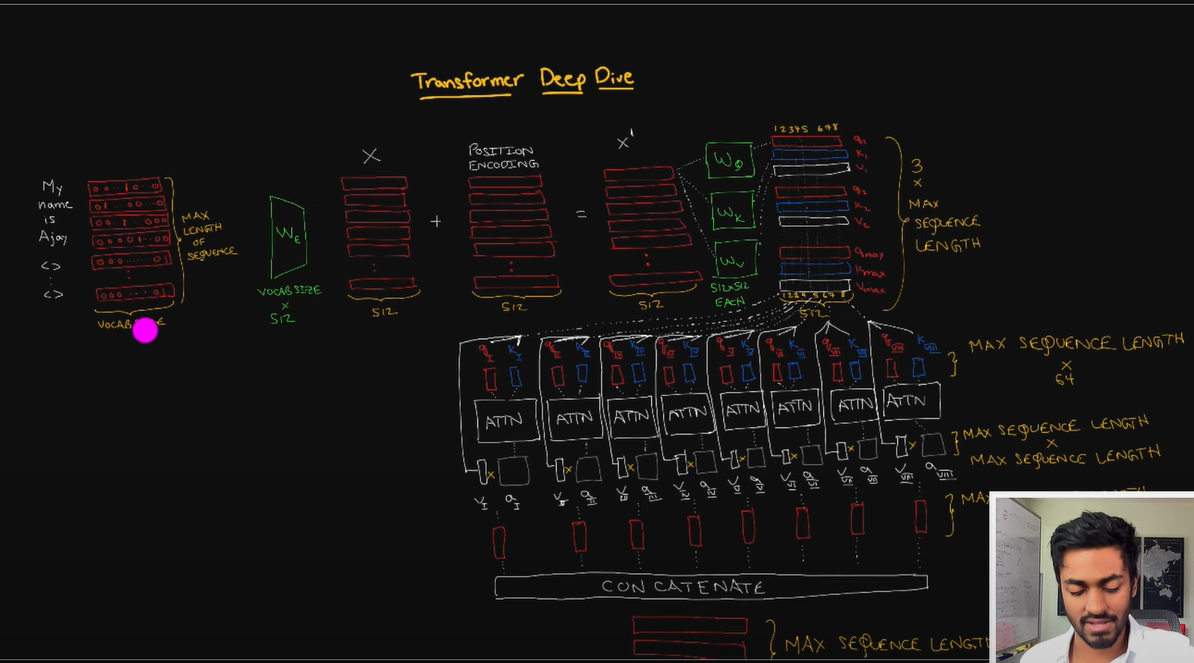

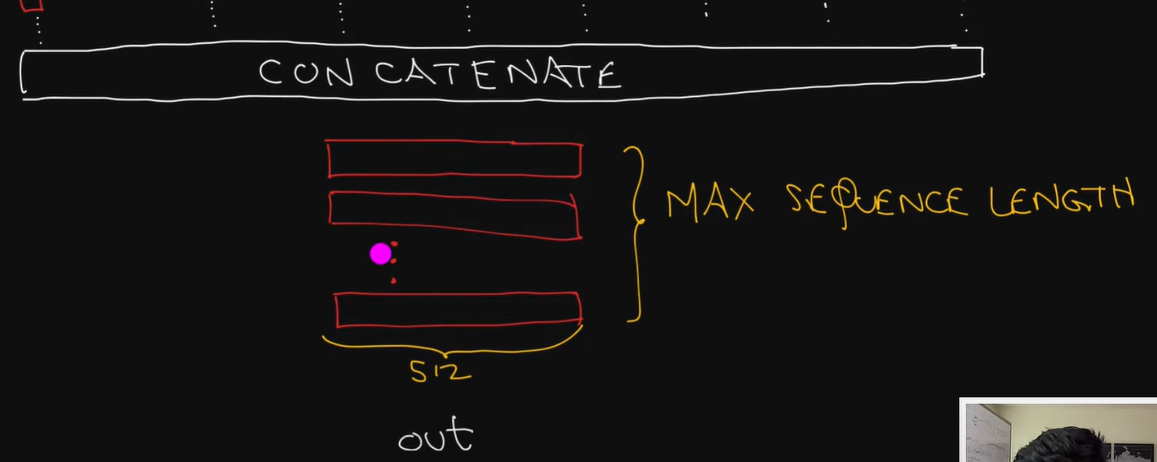

As we already seen in the previous cells, about the final out.values

all these things are happening

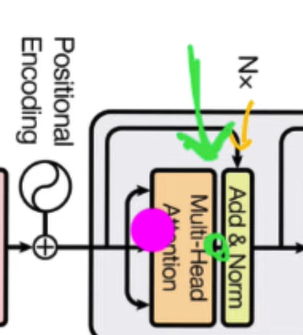

To prevent the vanishing gradient problem during backpropagation we have that line that is connected from

output of positional encoding ----> Add & Norm Layer

Layer Normalization
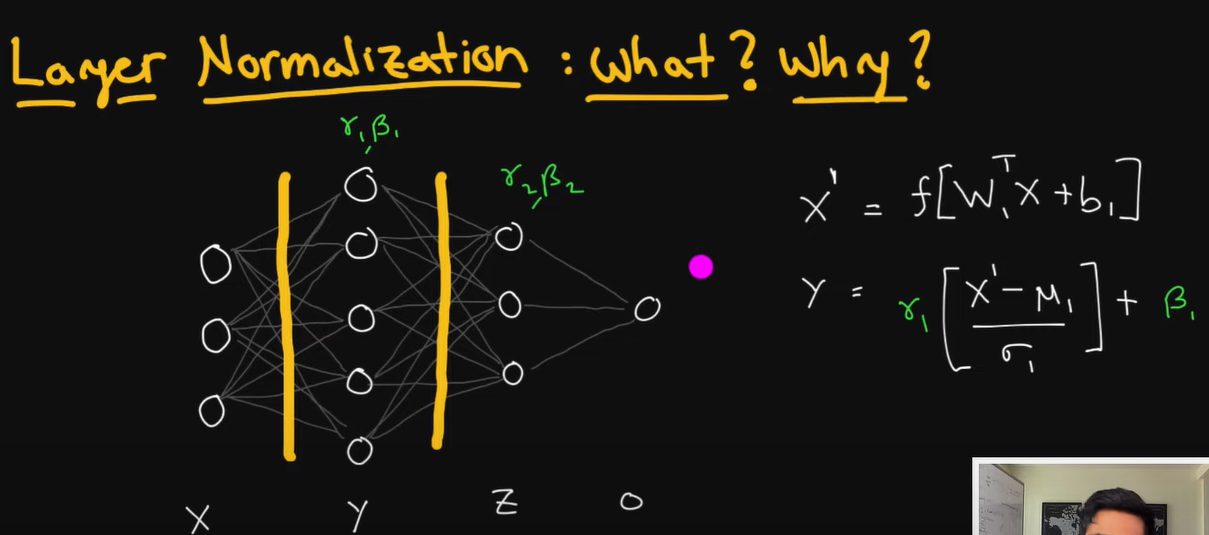

2 Words and 3 Dimensions

[[0.2,0.1,0.3],

[0.5,0.1,0.1]]

μ11 = (1/3)(0.2+0.1+0.3) = 0.2

μ21 = (1/3)(0.5+0.1+0.1) = 0.233

σ11 = sqrt((1/3){[0.2-0.2]^2 + [0.1-0.2]^2 + [0.3-0.2]^2} = 0.08164

Similarly we know how to calculate standard deviation

σ21 = 0.1885




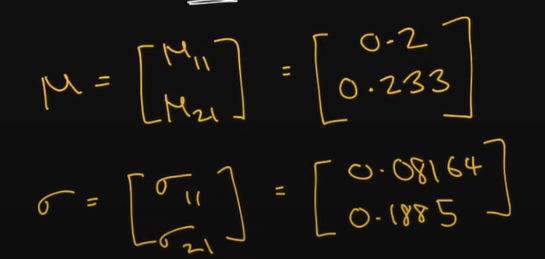



Y = (x-μ)/σ

out = γ*Y+Β


In [ ]:
import torch
from torch import nn

In [ ]:
inputs = torch.Tensor([[[0.2, 0.1, 0.3], [0.5, 0.1, 0.1]]])
B, S, E = inputs.size()
inputs = inputs.reshape(S, B, E)
inputs.size()

torch.Size([2, 1, 3])

In [ ]:
parameter_shape = inputs.size()[-2:]
gamma = nn.Parameter(torch.ones(parameter_shape))
beta =  nn.Parameter(torch.zeros(parameter_shape))

In [ ]:
gamma.size(), beta.size()

(torch.Size([1, 3]), torch.Size([1, 3]))

In [ ]:
dims = [-(i + 1) for i in range(len(parameter_shape))]

In [ ]:
dims

[-1, -2]

In [ ]:
mean = inputs.mean(dim=dims, keepdim=True)
mean.size()

torch.Size([2, 1, 1])

In [ ]:
mean

tensor([[[0.2000]],

        [[0.2333]]])

In [ ]:
var = ((inputs - mean) ** 2).mean(dim=dims, keepdim=True)
epsilon = 1e-5
std = (var + epsilon).sqrt()
std

tensor([[[0.0817]],

        [[0.1886]]])

In [ ]:
y = (inputs - mean) / std
y

tensor([[[ 0.0000, -1.2238,  1.2238]],

        [[ 1.4140, -0.7070, -0.7070]]])

In [ ]:
out = gamma * y + beta

In [ ]:
out

tensor([[[ 0.0000, -1.2238,  1.2238]],

        [[ 1.4140, -0.7070, -0.7070]]], grad_fn=<AddBackward0>)

# Class

In [ ]:
import torch
from torch import nn

class LayerNormalization():
    def __init__(self, parameters_shape, eps=1e-5):
        self.parameters_shape=parameters_shape
        self.eps=eps
        self.gamma = nn.Parameter(torch.ones(parameters_shape))
        self.beta =  nn.Parameter(torch.zeros(parameters_shape))

    def forward(self, input):
        dims = [-(i + 1) for i in range(len(self.parameters_shape))]
        mean = inputs.mean(dim=dims, keepdim=True)
        print(f"Mean \n ({mean.size()}): \n {mean}")
        var = ((inputs - mean) ** 2).mean(dim=dims, keepdim=True)
        std = (var + self.eps).sqrt()
        print(f"Standard Deviation \n ({std.size()}): \n {std}")
        y = (inputs - mean) / std
        print(f"y \n ({y.size()}) = \n {y}")
        out = self.gamma * y  + self.beta
        print(f"out \n ({out.size()}) = \n {out}")
        return out

In [ ]:
batch_size = 3
sentence_length = 5
embedding_dim = 8
inputs = torch.randn(sentence_length, batch_size, embedding_dim)

print(f"input \n ({inputs.size()}) = \n {inputs}")

input 
 (torch.Size([5, 3, 8])) = 
 tensor([[[ 0.5342,  1.6814, -0.5192,  0.8334, -0.5624, -2.7346,  0.9116,
           0.3691],
         [ 0.0512,  1.6459,  0.1987,  0.4266, -1.0790, -0.1693,  2.1018,
           0.9924],
         [-0.1508,  0.5968,  0.7744, -1.0132, -1.3749, -0.1774, -0.1702,
          -0.9035]],

        [[-1.0138,  0.4583,  1.9807, -0.6775,  0.0436,  0.1485,  0.7880,
          -0.0040],
         [-0.9876, -0.5967, -2.0680, -1.3698,  0.1779,  1.0581,  1.3346,
          -1.2803],
         [-1.4577, -0.0647,  0.2483,  0.5350, -0.1118,  0.4926, -0.2729,
          -0.4414]],

        [[-0.5163,  0.6202,  2.1178, -0.9989,  0.5999, -1.3291, -1.5996,
          -0.7170],
         [-1.2336, -0.6774,  0.3491, -0.3181,  0.4824, -0.1258,  0.3147,
          -0.1915],
         [ 1.0230, -0.0796, -0.5190, -0.6563, -0.9140, -0.0860,  0.2555,
           0.8995]],

        [[ 0.2358, -0.5858, -0.4048, -2.1728, -0.8933, -0.7175,  0.6321,
           1.1262],
         [ 1.8414, -0.8850, 

In [ ]:
layer_norm = LayerNormalization(inputs.size()[-1:])

In [ ]:
out = layer_norm.forward(inputs)

Mean 
 (torch.Size([5, 3, 1])): 
 tensor([[[ 0.0642],
         [ 0.5210],
         [-0.3024]],

        [[ 0.2155],
         [-0.4665],
         [-0.1341]],

        [[-0.2279],
         [-0.1750],
         [-0.0096]],

        [[-0.3475],
         [ 0.0747],
         [ 0.0030]],

        [[ 0.4188],
         [ 0.1320],
         [-0.0644]]])
Standard Deviation 
 (torch.Size([5, 3, 1])): 
 tensor([[[1.2652],
         [0.9590],
         [0.7107]],

        [[0.8583],
         [1.1355],
         [0.5977]],

        [[1.1682],
         [0.5412],
         [0.6585]],

        [[0.9551],
         [1.3647],
         [1.2770]],

        [[1.0620],
         [1.2201],
         [0.9403]]])
y 
 (torch.Size([5, 3, 8])) = 
 tensor([[[ 0.3715,  1.2782, -0.4611,  0.6080, -0.4953, -2.2122,  0.6698,
           0.2410],
         [-0.4900,  1.1730, -0.3361, -0.0985, -1.6685, -0.7199,  1.6484,
           0.4916],
         [ 0.2133,  1.2651,  1.5150, -1.0002, -1.5091,  0.1758,  0.1859,
          -0.8458]],



In [ ]:
out[0].mean(), out[0].std()

(tensor(-2.4835e-08, grad_fn=<MeanBackward0>),
 tensor(1.0215, grad_fn=<StdBackward0>))

#Transformer Encoder

In [ ]:
import torch
import math
from torch import nn
import torch.nn.functional as F

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    print(f"scaled.size() : {scaled.size()}")
    if mask is not None:
        print(f"-- ADDING MASK of shape {mask.size()} --")
        # Broadcasting add. So just the last N dimensions need to match
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class MultiHeadAttention(nn.Module):

    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(d_model , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        batch_size, max_sequence_length, d_model = x.size()
        print(f"x.size(): {x.size()}")
        qkv = self.qkv_layer(x)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.reshape(batch_size, max_sequence_length, self.num_heads, 3 * self.head_dim)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.permute(0, 2, 1, 3)
        print(f"qkv.size(): {qkv.size()}")
        q, k, v = qkv.chunk(3, dim=-1)
        print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")
        values, attention = scaled_dot_product(q, k, v, mask)
        print(f"values.size(): {values.size()}, attention.size:{ attention.size()} ")
        values = values.reshape(batch_size, max_sequence_length, self.num_heads * self.head_dim)
        print(f"values.size(): {values.size()}")
        out = self.linear_layer(values)
        print(f"out.size(): {out.size()}")
        return out


class LayerNormalization(nn.Module):
    def __init__(self, parameters_shape, eps=1e-5):
        super().__init__()
        self.parameters_shape=parameters_shape
        self.eps=eps
        self.gamma = nn.Parameter(torch.ones(parameters_shape))
        self.beta =  nn.Parameter(torch.zeros(parameters_shape))

    def forward(self, inputs): # 30 x 200 x 512
        dims = [-(i + 1) for i in range(len(self.parameters_shape))] # [-1]
        mean = inputs.mean(dim=dims, keepdim=True) # 30 x 200 x 1 if keepdim == True else it would have been 30 x 200
        print(f"Mean ({mean.size()})")
        var = ((inputs - mean) ** 2).mean(dim=dims, keepdim=True) # 30 x 200 x 1
        std = (var + self.eps).sqrt()
        print(f"Standard Deviation  ({std.size()})")
        y = (inputs - mean) / std # 30 x 200 x 512 -> is now layer normalized
        print(f"y: {y.size()}")
        out = self.gamma * y  + self.beta
        print(f"self.gamma: {self.gamma.size()}, self.beta: {self.beta.size()}")
        print(f"out: {out.size()}")
        return out


class PositionwiseFeedForward(nn.Module):

    def __init__(self, d_model, hidden, drop_prob=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x):
        x = self.linear1(x)
        print(f"x after first linear layer: {x.size()}")
        x = self.relu(x)
        print(f"x after activation: {x.size()}")
        x = self.dropout(x)
        print(f"x after dropout: {x.size()}")
        x = self.linear2(x)
        print(f"x after 2nd linear layer: {x.size()}")
        return x


class EncoderLayer(nn.Module):

    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
        super(EncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.norm1 = LayerNormalization(parameters_shape=[d_model])
        self.dropout1 = nn.Dropout(p=drop_prob)
        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.norm2 = LayerNormalization(parameters_shape=[d_model])
        self.dropout2 = nn.Dropout(p=drop_prob)

    def forward(self, x):
        residual_x = x
        print("------- ATTENTION 1 ------")
        x = self.attention(x, mask=None)
        print("------- DROPOUT 1 ------")
        x = self.dropout1(x)
        print("------- ADD AND LAYER NORMALIZATION 1 ------")
        x = self.norm1(x + residual_x)
        residual_x = x
        print("------- ATTENTION 2 ------")
        x = self.ffn(x)
        print("------- DROPOUT 2 ------")
        x = self.dropout2(x)
        print("------- ADD AND LAYER NORMALIZATION 2 ------")
        x = self.norm2(x + residual_x)
        return x


class Encoder(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob, num_layers):
        super().__init__()
        # Sequential for Nx to stack multiple encoder layers.
        self.layers = nn.Sequential(*[EncoderLayer(d_model, ffn_hidden, num_heads, drop_prob)
                                     for _ in range(num_layers)])

    def forward(self, x):
        # Here the x will be propagated through num_layers layers.
        x = self.layers(x)
        return x

In [ ]:
d_model = 512
num_heads = 8
drop_prob = 0.1
batch_size = 30
max_sequence_length = 200
ffn_hidden = 2048
num_layers = 5 # Nx


encoder = Encoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers)

In [ ]:
x = torch.randn( (batch_size, max_sequence_length, d_model) ) # includes positional encoding
out = encoder(x)


------- ATTENTION 1 ------
x.size(): torch.Size([30, 200, 512])
qkv.size(): torch.Size([30, 200, 1536])
qkv.size(): torch.Size([30, 200, 8, 192])
qkv.size(): torch.Size([30, 8, 200, 192])
q size: torch.Size([30, 8, 200, 64]), k size: torch.Size([30, 8, 200, 64]), v size: torch.Size([30, 8, 200, 64]), 
scaled.size() : torch.Size([30, 8, 200, 200])
values.size(): torch.Size([30, 8, 200, 64]), attention.size:torch.Size([30, 8, 200, 200]) 
values.size(): torch.Size([30, 200, 512])
out.size(): torch.Size([30, 200, 512])
------- DROPOUT 1 ------
------- ADD AND LAYER NORMALIZATION 1 ------
Mean (torch.Size([30, 200, 1]))
Standard Deviation  (torch.Size([30, 200, 1]))
y: torch.Size([30, 200, 512])
self.gamma: torch.Size([512]), self.beta: torch.Size([512])
out: torch.Size([30, 200, 512])
------- ATTENTION 2 ------
x after first linear layer: torch.Size([30, 200, 2048])
x after activation: torch.Size([30, 200, 2048])
x after dropout: torch.Size([30, 200, 2048])
x after 2nd linear layer: torch.

# Transformer Decoder

In [ ]:
import torch
import math
from torch import nn
import torch.nn.functional as F

def scaled_dot_product(q, k, v, mask=None):
    # q: 30 x 8 x 200 x 64, k: 30 x 8 x 200 x 64, v: 30 x 8 x 200 x 64, mask 200 x 200
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k) # 30 x 8 x 200 x 200
    print(f"scaled.size() : {scaled.size()}")
    if mask is not None:
        print(f"-- ADDING MASK of shape {mask.size()} --")
        scaled += mask # 30 x 8 x 200 x 200
    attention = F.softmax(scaled, dim=-1) # 30 x 8 x 200 x 200
    values = torch.matmul(attention, v) # 30 x 8 x 200 x 64
    return values, attention


class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, hidden, drop_prob=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x):
        #  x: 30 x 200 x 512
        x = self.linear1(x) #30 x 200 x 2048
        print(f"x after first linear layer: {x.size()}")
        x = self.relu(x) #30 x 200 x 2048
        print(f"x after relu layer: {x.size()}")
        x = self.dropout(x) #30 x 200 x 2048
        print(f"x after dropout layer: {x.size()}")
        x = self.linear2(x) #30 x 200 x 512
        print(f"x after 2nd linear layer: {x.size()}")
        return x #30 x 200 x 512


class LayerNormalization(nn.Module):
    def __init__(self, parameters_shape, eps=1e-5):
        super().__init__()
        self.parameters_shape=parameters_shape
        self.eps=eps
        self.gamma = nn.Parameter(torch.ones(parameters_shape)) # 512
        self.beta =  nn.Parameter(torch.zeros(parameters_shape)) # 512

    def forward(self, inputs):
        # inputs : 30 x 200 x 512
        dims = [-(i + 1) for i in range(len(self.parameters_shape))] # [-1]
        print(f"dims: {dims}")
        mean = inputs.mean(dim=dims, keepdim=True) #30 x 200 x 1
        print(f"Mean ({mean.size()})")
        var = ((inputs - mean) ** 2).mean(dim=dims, keepdim=True) # 30 x 200 x 512
        std = (var + self.eps).sqrt() # 30 x 200 x 512
        print(f"Standard Deviation  ({std.size()})")
        y = (inputs - mean) / std # 30 x 200 x 512
        print(f"y: {y.size()}")
        out = self.gamma * y  + self.beta  # 30 x 200 x 512
        print(f"out: {out.size()}")
        return out

class MultiHeadAttention(nn.Module):

    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(d_model , 3 * d_model) # 1536
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        batch_size, sequence_length, d_model = x.size() # 30 x 200 x 512
        print(f"x.size(): {x.size()}")
        qkv = self.qkv_layer(x) # 30 x 200 x 1536
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim) # 30 x 200 x 8 x 192
        print(f"qkv after reshape .size(): {qkv.size()}")
        qkv = qkv.permute(0, 2, 1, 3) # 30 x 8 x 200 x 192
        print(f"qkv after permutation: {qkv.size()}")
        q, k, v = qkv.chunk(3, dim=-1) # q: 30 x 8 x 200 x 64, k: 30 x 8 x 200 x 64, v: 30 x 8 x 200 x 64
        print(f"q: {q.size()}, k:{k.size()}, v:{v.size()}")
        values, attention = scaled_dot_product(q, k, v, mask) # values: 30 x 8 x 200 x 64
        print(f"values: {values.size()}, attention:{attention.size()}")
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim) # 30 x 200 x 512
        print(f"values after reshaping: {values.size()}")
        out = self.linear_layer(values) # 30 x 200 x 512
        print(f"out after passing through linear layer: {out.size()}")
        return out # 30 x 200 x 512


class MultiHeadCrossAttention(nn.Module):

    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.kv_layer = nn.Linear(d_model , 2 * d_model) # 1024
        self.q_layer = nn.Linear(d_model , d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, y, mask=None):
        batch_size, sequence_length, d_model = x.size() # 30 x 200 x 512
        print(f"x.size(): {x.size()}")
        kv = self.kv_layer(x) # 30 x 200 x 1024
        print(f"kv.size(): {kv.size()}")
        q = self.q_layer(y) # 30 x 200 x 512
        print(f"q.size(): {q.size()}")
        kv = kv.reshape(batch_size, sequence_length, self.num_heads, 2 * self.head_dim)  # 30 x 200 x 8 x 128
        q = q.reshape(batch_size, sequence_length, self.num_heads, self.head_dim)  # 30 x 200 x 8 x 64
        kv = kv.permute(0, 2, 1, 3) # 30 x 8 x 200 x 128
        q = q.permute(0, 2, 1, 3) # 30 x 8 x 200 x 64
        k, v = kv.chunk(2, dim=-1) # K: 30 x 8 x 200 x 64, v: 30 x 8 x 200 x 64
        values, attention = scaled_dot_product(q, k, v, mask) #  30 x 8 x 200 x 64
        print(f"values: {values.size()}, attention:{attention.size()}")
        values = values.reshape(batch_size, sequence_length, d_model) #  30 x 200 x 512
        out = self.linear_layer(values)  #  30 x 200 x 512
        print(f"out after passing through linear layer: {out.size()}")
        return out  #  30 x 200 x 512


class DecoderLayer(nn.Module):

    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
        super(DecoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.norm1 = LayerNormalization(parameters_shape=[d_model])
        self.dropout1 = nn.Dropout(p=drop_prob)
        self.encoder_decoder_attention = MultiHeadCrossAttention(d_model=d_model, num_heads=num_heads)
        self.norm2 = LayerNormalization(parameters_shape=[d_model])
        self.dropout2 = nn.Dropout(p=drop_prob)
        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.norm3 = LayerNormalization(parameters_shape=[d_model])
        self.dropout3 = nn.Dropout(p=drop_prob)

    def forward(self, x, y, decoder_mask):
        _y = y # 30 x 200 x 512
        print("MASKED SELF ATTENTION")
        y = self.self_attention(y, mask=decoder_mask) # 30 x 200 x 512
        print("DROP OUT 1")
        y = self.dropout1(y) # 30 x 200 x 512
        print("ADD + LAYER NORMALIZATION 1")
        y = self.norm1(y + _y) # 30 x 200 x 512

        _y = y # 30 x 200 x 512
        print("CROSS ATTENTION")
        y = self.encoder_decoder_attention(x, y, mask=None) #30 x 200 x 512
        print("DROP OUT 2")  #30 x 200 x 512
        y = self.dropout2(y)
        print("ADD + LAYER NORMALIZATION 2")
        y = self.norm2(y + _y)  #30 x 200 x 512

        _y = y  #30 x 200 x 512
        print("FEED FORWARD 1")
        y = self.ffn(y) #30 x 200 x 512
        print("DROP OUT 3")
        y = self.dropout3(y) #30 x 200 x 512
        print("ADD + LAYER NORMALIZATION 3")
        y = self.norm3(y + _y) #30 x 200 x 512
        return y #30 x 200 x 512

class SequentialDecoder(nn.Sequential):
    def forward(self, *inputs):
        x, y, mask = inputs
        for module in self._modules.values():
            y = module(x, y, mask) #30 x 200 x 512
        return y

class Decoder(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob, num_layers=1):
        super().__init__()
        self.layers = SequentialDecoder(*[DecoderLayer(d_model, ffn_hidden, num_heads, drop_prob)
                                          for _ in range(num_layers)])

    def forward(self, x, y, mask):
        #x : 30 x 200 x 512
        #y : 30 x 200 x 512
        #mask : 200 x 200
        y = self.layers(x, y, mask)
        return y #30 x 200 x 512

In [ ]:
d_model = 512
num_heads = 8
drop_prob = 0.1
batch_size = 30
max_sequence_length = 200
ffn_hidden = 2048
num_layers = 5

x = torch.randn( (batch_size, max_sequence_length, d_model) ) # English sentence positional encoded
y = torch.randn( (batch_size, max_sequence_length, d_model) ) # Hindi sentence positional encoded
mask = torch.full([max_sequence_length, max_sequence_length] , float('-inf'))
mask = torch.triu(mask, diagonal=1)
decoder = Decoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers)
out = decoder(x, y, mask)

MASKED SELF ATTENTION
x.size(): torch.Size([30, 200, 512])
qkv.size(): torch.Size([30, 200, 1536])
qkv after reshape .size(): torch.Size([30, 200, 8, 192])
qkv after permutation: torch.Size([30, 8, 200, 192])
q: torch.Size([30, 8, 200, 64]), k:torch.Size([30, 8, 200, 64]), v:torch.Size([30, 8, 200, 64])
scaled.size() : torch.Size([30, 8, 200, 200])
-- ADDING MASK of shape torch.Size([200, 200]) --
values: torch.Size([30, 8, 200, 64]), attention:torch.Size([30, 8, 200, 200])
values after reshaping: torch.Size([30, 200, 512])
out after passing through linear layer: torch.Size([30, 200, 512])
DROP OUT 1
ADD + LAYER NORMALIZATION 1
dims: [-1]
Mean (torch.Size([30, 200, 1]))
Standard Deviation  (torch.Size([30, 200, 1]))
y: torch.Size([30, 200, 512])
out: torch.Size([30, 200, 512])
CROSS ATTENTION
x.size(): torch.Size([30, 200, 512])
kv.size(): torch.Size([30, 200, 1024])
q.size(): torch.Size([30, 200, 512])
scaled.size() : torch.Size([30, 8, 200, 200])
values: torch.Size([30, 8, 200, 64]),

In [ ]:
mask, mask.shape

(tensor([[0., -inf, -inf,  ..., -inf, -inf, -inf],
         [0., 0., -inf,  ..., -inf, -inf, -inf],
         [0., 0., 0.,  ..., -inf, -inf, -inf],
         ...,
         [0., 0., 0.,  ..., 0., -inf, -inf],
         [0., 0., 0.,  ..., 0., 0., -inf],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([200, 200]))

In [ ]:
import torch
import numpy as np

In [ ]:
START_TOKEN = '<STR>'
PADDING_TOKEN = '<PAD>'
END_TOKEN = '<END>'

hindi_vocabulary = [START_TOKEN, ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/',
                    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '<', '=', '>', '?', 'ॐ',
                    'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ॠ', 'ए', 'ऐ', 'ओ', 'औ']

consonant = [ 'क', 'ख', 'ग', 'घ', 'ङ',
              'च', 'छ', 'ज', 'झ', 'ञ',
              'ट', 'ठ', 'ड', 'ढ', 'ण',
              'त', 'थ', 'द', 'ध', 'न',
              'प', 'फ', 'ब', 'भ', 'म',
              'य', 'र', 'ल', 'व', 'श', 'ष', 'स', 'ह']

vowel = ['ा', 'ि', 'ी', 'ु', 'ू', 'ृ', 'ॄ', 'ॅ', 'ॆ', 'े', 'ै', 'ॉ', 'ो', 'ौ', '्', 'ं', 'ः', 'ँ']

hindi_vocabulary += consonant

hindi_vocabulary += vowel
# for v in vowel:
#   for c in consonant:
#     hindi_vocabulary.append(c+v)

hindi_vocabulary += ['।', PADDING_TOKEN, END_TOKEN]

english_vocabulary = [START_TOKEN, ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/',
                        '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                        ':', '<', '=', '>', '?', '@',
                        'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
                        'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
                        'Y', 'Z',
                        '[', ']', '^', '_', '`',
                        'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
                        'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x',
                        'y', 'z',
                        '{', '|', '}', '~', PADDING_TOKEN, END_TOKEN]



In [ ]:
len(hindi_vocabulary), len(english_vocabulary)

(99, 96)

In [ ]:
consonant[0] , vowel[0], consonant[0] + vowel[0]

('क', 'ा', 'का')

In [ ]:
index_to_hindi = {k:v for k,v in enumerate(hindi_vocabulary)}
hindi_to_index = {v:k for k,v in enumerate(hindi_vocabulary)}
index_to_english = {k:v for k,v in enumerate(english_vocabulary)}
english_to_index = {v:k for k,v in enumerate(english_vocabulary)}

In [ ]:
import pandas as pd

In [ ]:
data = pd.read_parquet("/content/drive/MyDrive/eng-hindi-dataset/eng-hindi.parquet")

In [ ]:
data.shape

(1659083, 1)

In [ ]:
# Limit Number of sentences
TOTAL_SENTENCES = 459_083


In [ ]:
dataset = pd.DataFrame(data.iloc[0:TOTAL_SENTENCES].to_dict("list")["translation"])

In [ ]:
dataset_list = dataset.to_dict("list")

In [ ]:
english_sentences, hindi_sentences = dataset_list["en"], dataset_list["hi"]

In [ ]:
english_sentences[:10]

['Give your application an accessibility workout',
 'Accerciser Accessibility Explorer',
 'The default plugin layout for the bottom panel',
 'The default plugin layout for the top panel',
 'A list of plugins that are disabled by default',
 'Highlight duration',
 'The duration of the highlight box when selecting accessible nodes',
 'Highlight border color',
 'The color and opacity of the highlight border.',
 'Highlight fill color']

In [ ]:
hindi_sentences[:10]

['अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें',
 'एक्सेर्साइसर पहुंचनीयता अन्वेषक',
 'निचले पटल के लिए डिफोल्ट प्लग-इन खाका',
 'ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका',
 'उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से निष्क्रिय किया गया है',
 'अवधि को हाइलाइट रकें',
 'पहुंचनीय आसंधि (नोड) को चुनते समय हाइलाइट बक्से की अवधि',
 'सीमांत (बोर्डर) के रंग को हाइलाइट करें',
 'हाइलाइट किए गए सीमांत का रंग और अपारदर्शिता। ',
 'भराई के रंग को हाइलाइट करें']

In [ ]:
import numpy as np
PERCENTILE = 97
print( f"{PERCENTILE}th percentile length Hindi: {np.percentile([len(x) for x in hindi_sentences], PERCENTILE)}" )
print( f"{PERCENTILE}th percentile length English: {np.percentile([len(x) for x in english_sentences], PERCENTILE)}" )


97th percentile length Hindi: 318.0
97th percentile length English: 298.0


In [ ]:
max_sequence_length = 250

def is_valid_tokens(sentence, vocab):
    # print(f"sentence: {sentence}", end =" - ")
    for token in list(set(sentence)):
        if token not in vocab:
            return False
    return True

def is_valid_length(sentence, max_sequence_length):
    return len(list(sentence)) < (max_sequence_length - 1) # need to re-add the end token so leaving 1 space

valid_sentence_indicies = []
for index in range(len(hindi_sentences)):
    hindi_sentence, english_sentence = hindi_sentences[index], english_sentences[index]
    if is_valid_length(hindi_sentence, max_sequence_length) \
      and is_valid_length(english_sentence, max_sequence_length) \
      and is_valid_tokens(hindi_sentence, hindi_vocabulary) \
      and is_valid_tokens(english_sentence, english_vocabulary):
        valid_sentence_indicies.append(index)

print(f"Number of sentences: {len(hindi_sentences)}")
print(f"Number of valid sentences: {len(valid_sentence_indicies)}")

Number of sentences: 459083
Number of valid sentences: 181979


In [ ]:
hindi_sentences = [hindi_sentences[i] for i in valid_sentence_indicies]
english_sentences = [english_sentences[i] for i in valid_sentence_indicies]

In [ ]:
len(hindi_sentences), len(english_sentences)

(181979, 181979)

In [ ]:
english_sentences[:10], hindi_sentences[:10]

(['Give your application an accessibility workout',
  'Accerciser Accessibility Explorer',
  'The default plugin layout for the bottom panel',
  'The default plugin layout for the top panel',
  'A list of plugins that are disabled by default',
  'Highlight duration',
  'The duration of the highlight box when selecting accessible nodes',
  'Highlight border color',
  'The color and opacity of the highlight border.',
  'Highlight fill color'],
 ['अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें',
  'एक्सेर्साइसर पहुंचनीयता अन्वेषक',
  'निचले पटल के लिए डिफोल्ट प्लग-इन खाका',
  'ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका',
  'उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से निष्क्रिय किया गया है',
  'अवधि को हाइलाइट रकें',
  'पहुंचनीय आसंधि (नोड) को चुनते समय हाइलाइट बक्से की अवधि',
  'सीमांत (बोर्डर) के रंग को हाइलाइट करें',
  'हाइलाइट किए गए सीमांत का रंग और अपारदर्शिता। ',
  'भराई के रंग को हाइलाइट करें'])

In [ ]:
import numpy as np
import torch
import math
from torch import nn
import torch.nn.functional as F

def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled = scaled.permute(1, 0, 2, 3) + mask
        scaled = scaled.permute(1, 0, 2, 3)
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_sequence_length):
        super().__init__()
        self.max_sequence_length = max_sequence_length
        self.d_model = d_model

    def forward(self):
        even_i = torch.arange(0, self.d_model, 2).float()
        denominator = torch.pow(10000, even_i/self.d_model)
        position = (torch.arange(self.max_sequence_length)
                          .reshape(self.max_sequence_length, 1))
        even_PE = torch.sin(position / denominator)
        odd_PE = torch.cos(position / denominator)
        stacked = torch.stack([even_PE, odd_PE], dim=2)
        PE = torch.flatten(stacked, start_dim=1, end_dim=2)
        return PE

class SentenceEmbedding(nn.Module):
    "For a given sentence, create an embedding"
    def __init__(self, max_sequence_length, d_model, language_to_index, START_TOKEN, END_TOKEN, PADDING_TOKEN):
        super().__init__()
        self.vocab_size = len(language_to_index)
        self.max_sequence_length = max_sequence_length
        self.embedding = nn.Embedding(self.max_sequence_length, d_model)
        self.language_to_index = language_to_index
        self.position_encoder = PositionalEncoding(d_model, max_sequence_length)
        self.dropout = nn.Dropout(p=0.1)
        self.START_TOKEN = START_TOKEN
        self.END_TOKEN = END_TOKEN
        self.PADDING_TOKEN = PADDING_TOKEN

    def batch_tokenize(self, batch, start_token, end_token):

        def tokenize(sentence, start_token, end_token):
            try:
              sentence_word_indicies = [self.language_to_index[token] for token in list(sentence)]
            except:
              print("sentence:", sentence)
              print("self.language_to_index", self.language_to_index)
            if start_token:
                sentence_word_indicies.insert(0, self.language_to_index[self.START_TOKEN])
            if end_token:
                sentence_word_indicies.append(self.language_to_index[self.END_TOKEN])
            for _ in range(len(sentence_word_indicies), self.max_sequence_length):
                sentence_word_indicies.append(self.language_to_index[self.PADDING_TOKEN])
            return torch.tensor(sentence_word_indicies)

        tokenized = []
        for sentence_num in range(len(batch)):
           tokenized.append( tokenize(batch[sentence_num], start_token, end_token) )
        tokenized = torch.stack(tokenized)
        return tokenized.to(get_device())

    def forward(self, x, start_token, end_token): # sentence
        x = self.batch_tokenize(x, start_token, end_token)
        x = self.embedding(x)
        pos = self.position_encoder().to(get_device())
        x = self.dropout(x + pos)
        return x


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(d_model , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, mask):
        batch_size, sequence_length, d_model = x.size()
        qkv = self.qkv_layer(x)
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3)
        q, k, v = qkv.chunk(3, dim=-1)
        values, attention = scaled_dot_product(q, k, v, mask)
        values = values.permute(0, 2, 1, 3).reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        out = self.linear_layer(values)
        return out


class LayerNormalization(nn.Module):
    def __init__(self, parameters_shape, eps=1e-5):
        super().__init__()
        self.parameters_shape=parameters_shape
        self.eps=eps
        self.gamma = nn.Parameter(torch.ones(parameters_shape))
        self.beta =  nn.Parameter(torch.zeros(parameters_shape))

    def forward(self, inputs):
        dims = [-(i + 1) for i in range(len(self.parameters_shape))]
        mean = inputs.mean(dim=dims, keepdim=True)
        var = ((inputs - mean) ** 2).mean(dim=dims, keepdim=True)
        std = (var + self.eps).sqrt()
        y = (inputs - mean) / std
        out = self.gamma * y + self.beta
        return out


class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, hidden, drop_prob=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x


class EncoderLayer(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
        super(EncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.norm1 = LayerNormalization(parameters_shape=[d_model])
        self.dropout1 = nn.Dropout(p=drop_prob)
        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.norm2 = LayerNormalization(parameters_shape=[d_model])
        self.dropout2 = nn.Dropout(p=drop_prob)

    def forward(self, x, self_attention_mask):
        residual_x = x.clone()
        x = self.attention(x, mask=self_attention_mask)
        x = self.dropout1(x)
        x = self.norm1(x + residual_x)
        residual_x = x.clone()
        x = self.ffn(x)
        x = self.dropout2(x)
        x = self.norm2(x + residual_x)
        return x

class SequentialEncoder(nn.Sequential):
    def forward(self, *inputs):
        x, self_attention_mask  = inputs
        for module in self._modules.values():
            x = module(x, self_attention_mask)
        return x

class Encoder(nn.Module):
    def __init__(self,
                 d_model,
                 ffn_hidden,
                 num_heads,
                 drop_prob,
                 num_layers,
                 max_sequence_length,
                 language_to_index,
                 START_TOKEN,
                 END_TOKEN,
                 PADDING_TOKEN):
        super().__init__()
        self.sentence_embedding = SentenceEmbedding(max_sequence_length, d_model, language_to_index, START_TOKEN, END_TOKEN, PADDING_TOKEN)
        self.layers = SequentialEncoder(*[EncoderLayer(d_model, ffn_hidden, num_heads, drop_prob)
                                      for _ in range(num_layers)])

    def forward(self, x, self_attention_mask, start_token, end_token):
        x = self.sentence_embedding(x, start_token, end_token)
        x = self.layers(x, self_attention_mask)
        return x


class MultiHeadCrossAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.kv_layer = nn.Linear(d_model , 2 * d_model)
        self.q_layer = nn.Linear(d_model , d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, y, mask):
        batch_size, sequence_length, d_model = x.size() # in practice, this is the same for both languages...so we can technically combine with normal attention
        kv = self.kv_layer(x)
        q = self.q_layer(y)
        kv = kv.reshape(batch_size, sequence_length, self.num_heads, 2 * self.head_dim)
        q = q.reshape(batch_size, sequence_length, self.num_heads, self.head_dim)
        kv = kv.permute(0, 2, 1, 3)
        q = q.permute(0, 2, 1, 3)
        k, v = kv.chunk(2, dim=-1)
        values, attention = scaled_dot_product(q, k, v, mask) # We don't need the mask for cross attention, removing in outer function!
        values = values.permute(0, 2, 1, 3).reshape(batch_size, sequence_length, d_model)
        out = self.linear_layer(values)
        return out


class DecoderLayer(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
        super(DecoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.layer_norm1 = LayerNormalization(parameters_shape=[d_model])
        self.dropout1 = nn.Dropout(p=drop_prob)

        self.encoder_decoder_attention = MultiHeadCrossAttention(d_model=d_model, num_heads=num_heads)
        self.layer_norm2 = LayerNormalization(parameters_shape=[d_model])
        self.dropout2 = nn.Dropout(p=drop_prob)

        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.layer_norm3 = LayerNormalization(parameters_shape=[d_model])
        self.dropout3 = nn.Dropout(p=drop_prob)

    def forward(self, x, y, self_attention_mask, cross_attention_mask):
        _y = y.clone()
        y = self.self_attention(y, mask=self_attention_mask)
        y = self.dropout1(y)
        y = self.layer_norm1(y + _y)

        _y = y.clone()
        y = self.encoder_decoder_attention(x, y, mask=cross_attention_mask)
        y = self.dropout2(y)
        y = self.layer_norm2(y + _y)

        _y = y.clone()
        y = self.ffn(y)
        y = self.dropout3(y)
        y = self.layer_norm3(y + _y)
        return y


class SequentialDecoder(nn.Sequential):
    def forward(self, *inputs):
        x, y, self_attention_mask, cross_attention_mask = inputs
        for module in self._modules.values():
            y = module(x, y, self_attention_mask, cross_attention_mask)
        return y

class Decoder(nn.Module):
    def __init__(self,
                 d_model,
                 ffn_hidden,
                 num_heads,
                 drop_prob,
                 num_layers,
                 max_sequence_length,
                 language_to_index,
                 START_TOKEN,
                 END_TOKEN,
                 PADDING_TOKEN):
        super().__init__()
        self.sentence_embedding = SentenceEmbedding(max_sequence_length, d_model, language_to_index, START_TOKEN, END_TOKEN, PADDING_TOKEN)
        self.layers = SequentialDecoder(*[DecoderLayer(d_model, ffn_hidden, num_heads, drop_prob) for _ in range(num_layers)])

    def forward(self, x, y, self_attention_mask, cross_attention_mask, start_token, end_token):
        y = self.sentence_embedding(y, start_token, end_token)
        y = self.layers(x, y, self_attention_mask, cross_attention_mask)
        return y


class Transformer(nn.Module):
    def __init__(self,
                d_model,
                ffn_hidden,
                num_heads,
                drop_prob,
                num_layers,
                max_sequence_length,
                hi_vocab_size,
                english_to_index,
                hindi_to_index,
                START_TOKEN,
                END_TOKEN,
                PADDING_TOKEN
                ):
        super().__init__()
        self.encoder = Encoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers, max_sequence_length, english_to_index, START_TOKEN, END_TOKEN, PADDING_TOKEN)
        self.decoder = Decoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers, max_sequence_length, hindi_to_index, START_TOKEN, END_TOKEN, PADDING_TOKEN)

        self.linear = nn.Linear(d_model, hi_vocab_size)
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    def forward(self,
                x,
                y,
                encoder_self_attention_mask=None,
                decoder_self_attention_mask=None,
                decoder_cross_attention_mask=None,
                enc_start_token=False,
                enc_end_token=False,
                dec_start_token=False, # We should make this true
                dec_end_token=False): # x, y are batch of sentences
        x = self.encoder(x, encoder_self_attention_mask, start_token=enc_start_token, end_token=enc_end_token)
        out = self.decoder(x, y, decoder_self_attention_mask, decoder_cross_attention_mask, start_token=dec_start_token, end_token=dec_end_token)
        out = self.linear(out)
        return out

In [ ]:

import torch

d_model = 512
batch_size = 128
ffn_hidden = 2048
num_heads = 8
drop_prob = 0.1
num_layers = 2
max_sequence_length = 250
hi_vocab_size = len(hindi_vocabulary)

transformer = Transformer(d_model,
                          ffn_hidden,
                          num_heads,
                          drop_prob,
                          num_layers,
                          max_sequence_length,
                          hi_vocab_size,
                          english_to_index,
                          hindi_to_index,
                          START_TOKEN,
                          END_TOKEN,
                          PADDING_TOKEN)

In [ ]:
transformer

Transformer(
  (encoder): Encoder(
    (sentence_embedding): SentenceEmbedding(
      (embedding): Embedding(250, 512)
      (position_encoder): PositionalEncoding()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): SequentialEncoder(
      (0): EncoderLayer(
        (attention): MultiHeadAttention(
          (qkv_layer): Linear(in_features=512, out_features=1536, bias=True)
          (linear_layer): Linear(in_features=512, out_features=512, bias=True)
        )
        (norm1): LayerNormalization()
        (dropout1): Dropout(p=0.1, inplace=False)
        (ffn): PositionwiseFeedForward(
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (linear2): Linear(in_features=2048, out_features=512, bias=True)
          (relu): ReLU()
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (norm2): LayerNormalization()
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): EncoderLayer(
        (attention): MultiHeadA

In [ ]:
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):

    def __init__(self, english_sentences, hindi_sentences):
        self.english_sentences = english_sentences
        self.hindi_sentences = hindi_sentences

    def __len__(self):
        return len(self.english_sentences)

    def __getitem__(self, idx):
        return self.english_sentences[idx], self.hindi_sentences[idx]

In [ ]:
dataset = TextDataset(english_sentences, hindi_sentences)

In [ ]:
len(dataset)

181979

In [ ]:
dataset[:10]

(['Give your application an accessibility workout',
  'Accerciser Accessibility Explorer',
  'The default plugin layout for the bottom panel',
  'The default plugin layout for the top panel',
  'A list of plugins that are disabled by default',
  'Highlight duration',
  'The duration of the highlight box when selecting accessible nodes',
  'Highlight border color',
  'The color and opacity of the highlight border.',
  'Highlight fill color'],
 ['अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें',
  'एक्सेर्साइसर पहुंचनीयता अन्वेषक',
  'निचले पटल के लिए डिफोल्ट प्लग-इन खाका',
  'ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका',
  'उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से निष्क्रिय किया गया है',
  'अवधि को हाइलाइट रकें',
  'पहुंचनीय आसंधि (नोड) को चुनते समय हाइलाइट बक्से की अवधि',
  'सीमांत (बोर्डर) के रंग को हाइलाइट करें',
  'हाइलाइट किए गए सीमांत का रंग और अपारदर्शिता। ',
  'भराई के रंग को हाइलाइट करें'])

In [ ]:
train_loader = DataLoader(dataset, batch_size)
iterator = iter(train_loader)

In [ ]:
for batch_num, batch in enumerate(iterator):
    print(batch)
    if batch_num > 3:
        break

[('Give your application an accessibility workout', 'Accerciser Accessibility Explorer', 'The default plugin layout for the bottom panel', 'The default plugin layout for the top panel', 'A list of plugins that are disabled by default', 'Highlight duration', 'The duration of the highlight box when selecting accessible nodes', 'Highlight border color', 'The color and opacity of the highlight border.', 'Highlight fill color', 'The color and opacity of the highlight fill.', 'API Browser', 'Browse the various methods of the current accessible', 'Hide private attributes', 'Method', 'Property', 'Value', 'IPython Console', 'Interactive console for manipulating currently selected accessible', 'Event monitor', 'Everything', 'Selected application', 'Selected accessible', 'Source', 'Event Monitor', 'Shows events as they occur from selected types and sources', 'Highlight last event entry', 'Start / stop event recording', 'Clear event log', '(no description)', 'Description', 'Show', '_ Accessible', 

In [ ]:
from torch import nn

criterian = nn.CrossEntropyLoss(ignore_index=hindi_to_index[PADDING_TOKEN],
                                reduction='none')

# When computing the loss, we are ignoring cases when the label is the padding token
for params in transformer.parameters():
    if params.dim() > 1:
        nn.init.xavier_uniform_(params)

optim = torch.optim.Adam(transformer.parameters(), lr=1e-4)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
NEG_INFTY = -1e9

def create_masks(eng_batch, hi_batch):
    num_sentences = len(eng_batch)
    look_ahead_mask = torch.full([max_sequence_length, max_sequence_length] , True)
    look_ahead_mask = torch.triu(look_ahead_mask, diagonal=1)
    encoder_padding_mask = torch.full([num_sentences, max_sequence_length, max_sequence_length] , False)
    decoder_padding_mask_self_attention = torch.full([num_sentences, max_sequence_length, max_sequence_length] , False)
    decoder_padding_mask_cross_attention = torch.full([num_sentences, max_sequence_length, max_sequence_length] , False)

    for idx in range(num_sentences):
      eng_sentence_length, hi_sentence_length = len(eng_batch[idx]), len(hi_batch[idx])
      eng_chars_to_padding_mask = np.arange(eng_sentence_length + 1, max_sequence_length)
      hi_chars_to_padding_mask = np.arange(hi_sentence_length + 1, max_sequence_length)
      encoder_padding_mask[idx, :, eng_chars_to_padding_mask] = True
      encoder_padding_mask[idx, eng_chars_to_padding_mask, :] = True
      decoder_padding_mask_self_attention[idx, :, hi_chars_to_padding_mask] = True
      decoder_padding_mask_self_attention[idx, hi_chars_to_padding_mask, :] = True
      decoder_padding_mask_cross_attention[idx, :, eng_chars_to_padding_mask] = True
      decoder_padding_mask_cross_attention[idx, hi_chars_to_padding_mask, :] = True

    encoder_self_attention_mask = torch.where(encoder_padding_mask, NEG_INFTY, 0)
    decoder_self_attention_mask =  torch.where(look_ahead_mask + decoder_padding_mask_self_attention, NEG_INFTY, 0)
    decoder_cross_attention_mask = torch.where(decoder_padding_mask_cross_attention, NEG_INFTY, 0)
    return encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask

In [ ]:
transformer.train()
transformer.to(device)
total_loss = 0
num_epochs = 10

for epoch in range(num_epochs):
    print(f"Epoch {epoch}")
    iterator = iter(train_loader)
    for batch_num, batch in enumerate(iterator):
        transformer.train()
        eng_batch, hi_batch = batch
        encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask = create_masks(eng_batch, hi_batch)
        optim.zero_grad()
        hi_predictions = transformer(eng_batch,
                                     hi_batch,
                                     encoder_self_attention_mask.to(device),
                                     decoder_self_attention_mask.to(device),
                                     decoder_cross_attention_mask.to(device),
                                     enc_start_token=False,
                                     enc_end_token=False,
                                     dec_start_token=True,
                                     dec_end_token=True)
        labels = transformer.decoder.sentence_embedding.batch_tokenize(hi_batch, start_token=False, end_token=True)
        loss = criterian(
            hi_predictions.view(-1, hi_vocab_size).to(device),
            labels.view(-1).to(device)
        ).to(device)
        valid_indicies = torch.where(labels.view(-1) == hindi_to_index[PADDING_TOKEN], False, True)
        loss = loss.sum() / valid_indicies.sum()
        loss.backward()
        optim.step()
        #train_losses.append(loss.item())
        if batch_num % 100 == 0:
            print(f"Iteration {batch_num} : {loss.item()}")
            print(f"English: {eng_batch[0]}")
            print(f"Hindi Translation: {hi_batch[0]}")
            hi_sentence_predicted = torch.argmax(hi_predictions[0], axis=1)
            predicted_sentence = ""
            for idx in hi_sentence_predicted:
              if idx == hindi_to_index[END_TOKEN]:
                break
              predicted_sentence += index_to_hindi[idx.item()]
            print(f"Hindi Prediction: {predicted_sentence}")


            transformer.eval()
            hi_sentence = ("",)
            eng_sentence = ("should we go to the mall?",)
            for word_counter in range(max_sequence_length):
                encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask= create_masks(eng_sentence, hi_sentence)
                predictions = transformer(eng_sentence,
                                          hi_sentence,
                                          encoder_self_attention_mask.to(device),
                                          decoder_self_attention_mask.to(device),
                                          decoder_cross_attention_mask.to(device),
                                          enc_start_token=False,
                                          enc_end_token=False,
                                          dec_start_token=True,
                                          dec_end_token=False)
                next_token_prob_distribution = predictions[0][word_counter] # not actual probs
                next_token_index = torch.argmax(next_token_prob_distribution).item()
                next_token = index_to_hindi[next_token_index]
                hi_sentence = (hi_sentence[0] + next_token, )
                if next_token == END_TOKEN:
                  break

            print(f"Evaluation translation (should we go to the mall?) : {hi_sentence}")
            print("-------------------------------------------")

Epoch 0
Iteration 0 : 5.43602180480957
English: Give your application an accessibility workout
Hindi Translation: अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें
Hindi Prediction: ाझाहहॐॐ0हहहाहेे3ा3हाऐेुह3ॐहहह>ऐऐबऐे0ाऐऐेहहहे3हेेॐॐएॐॐॐॐॉॐाा।ॐॐॄॐॐॐॐॐॐॐॐेॐाहहॐॐहॐॐ0ॐॐ0ॐ0ॐ0ॐमॐहहहाएॐब0ए0एतूशूू#ाूा#0ए0ॐॐ0ए#एएतएूभ0###ॐ#एॐ>ू0ह0ॐ00ॐ#0ॐ0030#ॐ000े0ॐॐॐॐॐ00हश0हॐ0तॐाॐााॐॐाॐॐऐाॐाॐॐॐााॐाॐाहहहहहह0ॐ0हॐॐ03ॐ00ॐ0000ॉश00ॐ0ॐॐत0ॐ3ॐशहॐ0ॐॐॐठ0ॐॐतॐॐॐॐॐॐॐॐ
Evaluation translation (should we go to the mall?) : ('                                                                                                                                                                                                                                                          ',)
-------------------------------------------
Iteration 100 : 3.4330525398254395
English: Sign this tag
Hindi Translation: इस टैग को हस्ताक्षर करें
Hindi Prediction: स्ा््ा   
Evaluation translation (should we go to the mall?) : ('स््         <END>',)
----------

In [ ]:
transformer.eval()
def translate(eng_sentence):
  eng_sentence = (eng_sentence,)
  hi_sentence = ("",)
  for word_counter in range(max_sequence_length):
    encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask= create_masks(eng_sentence, hi_sentence)
    predictions = transformer(eng_sentence,
                              hi_sentence,
                              encoder_self_attention_mask.to(device),
                              decoder_self_attention_mask.to(device),
                              decoder_cross_attention_mask.to(device),
                              enc_start_token=False,
                              enc_end_token=False,
                              dec_start_token=True,
                              dec_end_token=False)
    next_token_prob_distribution = predictions[0][word_counter]
    next_token_index = torch.argmax(next_token_prob_distribution).item()
    next_token = index_to_hindi[next_token_index]
    hi_sentence = (hi_sentence[0] + next_token, )
    if next_token == END_TOKEN:
      break
  return hi_sentence[0]

In [ ]:
translation = translate("what should we do when the day starts?")
print(translation)

In [ ]:
translation = translate("what is your name?")
print(translation)

In [ ]:
translation = translate("color")
print(translation)

In [ ]:
translation = translate("colour")
print(translation)

In [ ]:
translation = translate("just awesome!")
print(translation)

In [ ]:
translation = translate("message!")
print(translation)

In [ ]:
translation = translate("book!")
print(translation)

In [ ]:
translation = translate("What, where and how?")
print(translation)

In [ ]:
translation = translate("you?")
print(translation)

In [ ]:
translation = translate("crazy thing!!")
print(translation)

In [ ]:
translation = translate("i am here!")
print(translation)

मैं आर! <END>


In [ ]:
translation = translate("I got lost!")
print(translation)

यह मैं है! <END>


In [ ]:
translation = translate("it's me!")
print(translation)

यह मेर! <END>


In [ ]:
translation = translate("that's mine!")
print(translation)

तो में है! <END>


In [ ]:
translation = translate("click this!")
print(translation)

क्लास करें! <END>


In [ ]:
translation = translate("do this!")
print(translation)

संपादन है! <END>


In [ ]:
translation = translate("do!")
print(translation)

को! <END>


In [ ]:
translation = translate("what?")
print(translation)

क्या? <END>


In [ ]:
translation = translate("why?")
print(translation)

क्या? <END>


In [ ]:
translation = translate("Frame")
print(translation)

फ्रेम<END>


In [ ]:
pytorch_total_params = sum(p.numel() for p in transformer.parameters() if p.requires_grad)
print("total params: ",pytorch_total_params)

In [ ]:
print("asdf asdf asdf asdf asdf asdf asdf asdf asdf ")

asdf asdf asdf asdf asdf asdf asdf asdf asdf 


In [ ]:
torch.save(transformer.state_dict(), '/content/drive/MyDrive/eng-hindi-dataset/model-3rd-run-2-layers-10-epoch.pth')

In [ ]:
torch.save(transformer, '/content/drive/MyDrive/eng-hindi-dataset/transformer-3rd-run-2-layers-10-epoch.pt')

In [ ]:
import pandas as pd

In [ ]:
data = pd.read_parquet("/content/drive/MyDrive/eng-hindi-dataset/eng-hindi.parquet")

In [ ]:
data.shape

(1659083, 1)

In [ ]:
# Limit Number of sentences
TOTAL_SENTENCES = 159_083

In [ ]:
dataset = pd.DataFrame(data.iloc[0:TOTAL_SENTENCES].to_dict("list")["translation"])

In [ ]:
dataset_list = dataset.to_dict("list")

In [ ]:
english_sentences, hindi_sentences = dataset_list["en"], dataset_list["hi"]

In [ ]:
len(english_sentences)

159083

In [ ]:
english_sentences[:10]

['Give your application an accessibility workout',
 'Accerciser Accessibility Explorer',
 'The default plugin layout for the bottom panel',
 'The default plugin layout for the top panel',
 'A list of plugins that are disabled by default',
 'Highlight duration',
 'The duration of the highlight box when selecting accessible nodes',
 'Highlight border color',
 'The color and opacity of the highlight border.',
 'Highlight fill color']

In [ ]:
hindi_sentences[:10]

['अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें',
 'एक्सेर्साइसर पहुंचनीयता अन्वेषक',
 'निचले पटल के लिए डिफोल्ट प्लग-इन खाका',
 'ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका',
 'उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से निष्क्रिय किया गया है',
 'अवधि को हाइलाइट रकें',
 'पहुंचनीय आसंधि (नोड) को चुनते समय हाइलाइट बक्से की अवधि',
 'सीमांत (बोर्डर) के रंग को हाइलाइट करें',
 'हाइलाइट किए गए सीमांत का रंग और अपारदर्शिता। ',
 'भराई के रंग को हाइलाइट करें']

In [ ]:
import torchtext
from torchtext.data.utils import get_tokenizer

# Define the tokenizers for English and Hindi
tokenizer_en = get_tokenizer('spacy', language='en_core_web_sm')
tokenizer_hi = get_tokenizer('spacy', language='en_core_web_sm')

# Tokenize the sentences
tokenized_sentences_en = [tokenizer_en(sentence.lower()) for sentence in english_sentences]
tokenized_sentences_hi = [tokenizer_hi(sentence.lower()) for sentence in hindi_sentences]

# Build vocabulary for English
english_vocab = torchtext.vocab.build_vocab_from_iterator(tokenized_sentences_en, specials=['<unk>', '<pad>', '<bos>', '<eos>'])

# Build vocabulary for Hindi
hindi_vocab = torchtext.vocab.build_vocab_from_iterator(tokenized_sentences_hi, specials=['<unk>', '<pad>', '<bos>', '<eos>'])


In [ ]:
import nltk

In [ ]:
import nltk
from nltk.tokenize import word_tokenize

# Download the Punkt tokenizer models for English and Hindi
nltk.download('punkt')

# Tokenize the sentences
tokenized_sentences_en = [word_tokenize(sentence.lower()) for sentence in english_sentences]
tokenized_sentences_hi = [word_tokenize(sentence.lower()) for sentence in hindi_sentences]

# Rest of the code remains the same...


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
tokenized_sentences_en[:5]

[['give', 'your', 'application', 'an', 'accessibility', 'workout'],
 ['accerciser', 'accessibility', 'explorer'],
 ['the', 'default', 'plugin', 'layout', 'for', 'the', 'bottom', 'panel'],
 ['the', 'default', 'plugin', 'layout', 'for', 'the', 'top', 'panel'],
 ['a', 'list', 'of', 'plugins', 'that', 'are', 'disabled', 'by', 'default']]

In [ ]:
tokenized_sentences_hi[:5]

[['अपने', 'अनुप्रयोग', 'को', 'पहुंचनीयता', 'व्यायाम', 'का', 'लाभ', 'दें'],
 ['एक्सेर्साइसर', 'पहुंचनीयता', 'अन्वेषक'],
 ['निचले', 'पटल', 'के', 'लिए', 'डिफोल्ट', 'प्लग-इन', 'खाका'],
 ['ऊपरी', 'पटल', 'के', 'लिए', 'डिफोल्ट', 'प्लग-इन', 'खाका'],
 ['उन',
  'प्लग-इनों',
  'की',
  'सूची',
  'जिन्हें',
  'डिफोल्ट',
  'रूप',
  'से',
  'निष्क्रिय',
  'किया',
  'गया',
  'है']]

In [ ]:
import torch
import torchtext

# Build vocabulary for English
english_vocab = torchtext.vocab.build_vocab_from_iterator(tokenized_sentences_en, specials=['<unk>', '<pad>', '<bos>', '<eos>'])

# Build vocabulary for Hindi
hindi_vocab = torchtext.vocab.build_vocab_from_iterator(tokenized_sentences_hi, specials=['<unk>', '<pad>', '<bos>', '<eos>'])

# Indexing and Padding (similar to the previous example)
indexed_sentences_en = [torch.tensor([english_vocab[token] for token in sentence], dtype=torch.long) for sentence in tokenized_sentences_en]
indexed_sentences_hi = [torch.tensor([hindi_vocab[token] for token in sentence], dtype=torch.long) for sentence in tokenized_sentences_hi]

padded_sentences_en = torch.nn.utils.rnn.pad_sequence(indexed_sentences_en, padding_value=english_vocab['<pad>'])
padded_sentences_hi = torch.nn.utils.rnn.pad_sequence(indexed_sentences_hi, padding_value=hindi_vocab['<pad>'])


In [ ]:
indexed_sentences_en[:10]

[tensor([1033,   46,  273,   45, 1394, 5161]),
 tensor([1998, 1394, 3190]),
 tensor([   4,  105,  115,  459,   17,    4,  596, 1163]),
 tensor([   4,  105,  115,  459,   17,    4,  444, 1163]),
 tensor([ 11,  33,  13, 288,  79,  55, 834,  72, 105]),
 tensor([455, 767]),
 tensor([   4,  767,   13,    4,  455,  554,   83, 1193,  454, 3409]),
 tensor([ 455, 1074,  125]),
 tensor([   4,  125,   27, 1496,   13,    4,  455, 1074,    5]),
 tensor([455, 529, 125])]

In [ ]:
padded_sentences_en[:].shape

torch.Size([5, 159083])

In [ ]:
import torch
from transformers import BertTokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
tokenizer.tokenize("Hello there! \n How are you?")

['hello', 'there', '!', 'how', 'are', 'you', '?']